In [ ]:
import sys
from pathlib import Path

project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import torch
import torch.nn as nn
from torchvision import models, transforms
from transformers import RobertaTokenizer, RobertaModel
from sklearn.cluster import KMeans
import cv2
import os

# Use GPU 1 instead of GPU 0
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

plt.style.use('seaborn-v0_8-paper')
plt.rcParams['figure.dpi'] = 100

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"✓ Imports successful")
print(f"Project root: {project_root}")
print(f"PyTorch: {torch.__version__}")
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    torch.cuda.empty_cache()

/data/paloma/venvs/cerebrum-artis/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


✓ Imports successful
Project root: /home/paloma/cerebrum-artis
PyTorch: 1.12.1+cu102
CUDA available: True


In [2]:
import gc
import torch

if torch.cuda.is_available():
    print("Cleaning GPU memory...")
    torch.cuda.empty_cache()
    gc.collect()
    
    allocated = torch.cuda.memory_allocated(0) / 1024**3
    reserved = torch.cuda.memory_reserved(0) / 1024**3
    print(f"  GPU 0: {allocated:.2f} GB allocated, {reserved:.2f} GB reserved")
    
    if reserved > 1.0:
        print(f"  {reserved:.2f} GB still reserved - restart kernel if needed")
    else:
        print(f" GPU memory cleaned!")
else:
    print("CUDA not available")

Cleaning GPU memory...
  GPU 0: 0.00 GB allocated, 0.00 GB reserved
 GPU memory cleaned!


## 1. Setup: Load Models & Helpers

Vamos carregar os modelos V3, V4, V4.1 que já avaliamos e criar funções helper para análise.

In [3]:
sys.path.insert(0, str(project_root / 'cerebrum_artis' / 'models' / 'v3_fuzzy_features'))
from train_v3 import MultimodalFuzzyClassifier as V3Model

# V4 Model
class FuzzyGatingClassifier(nn.Module):
    """V4: Neural network with fuzzy gating"""
    
    def __init__(self, num_classes=9, fuzzy_dim=7, dropout=0.3, freeze_resnet=True):
        super().__init__()
        resnet = models.resnet50(weights='IMAGENET1K_V1')
        self.visual_encoder = nn.Sequential(*list(resnet.children())[:-1])
        if freeze_resnet:
            for param in self.visual_encoder.parameters():
                param.requires_grad = False
        self.text_encoder = RobertaModel.from_pretrained('roberta-base')
        self.classifier = nn.Sequential(
            nn.Linear(2048 + 768, 1024), nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(1024, 512), nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, image, text_input_ids, text_attention_mask, fuzzy_features=None):
        visual_feats = self.visual_encoder(image).view(image.size(0), -1)
        text_output = self.text_encoder(input_ids=text_input_ids, attention_mask=text_attention_mask)
        text_feats = text_output.last_hidden_state[:, 0, :]
        combined = torch.cat([visual_feats, text_feats], dim=1)
        return self.classifier(combined)

V4Model = FuzzyGatingClassifier

V4_1Model = FuzzyGatingClassifier

EMOTION_LABELS = [
    'amusement', 'awe', 'contentment', 'excitement',
    'anger', 'disgust', 'fear', 'sadness', 'something else'
]

print("✓ Model architectures defined")
print(f"✓ {len(EMOTION_LABELS)} emotion classes")

✓ Model architectures defined
✓ 9 emotion classes


## 2. Load Sample Image

Vamos usar uma imagem do dataset WikiArt para testar.

In [4]:
wikiart_dir = Path('/data/paloma/data/paintings/wikiart/Rococo/')

# Define device early (needed for tensor creation)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

import random
all_images = list(wikiart_dir.rglob('*.jpg'))
if all_images:
    sample_image_path = random.choice(all_images[:100]) 
    print(f"Selected random artwork: {sample_image_path.name}")
    print(f"  Style: {sample_image_path.parent.name}")
    
    image = Image.open(sample_image_path).convert('RGB')
    
    # Create image tensor for models
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(image)
    ax.axis('off')
    ax.set_title(f'Sample Artwork\n{sample_image_path.parent.name} / {sample_image_path.name}',
                fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print(f"✓ Image size: {image.size}")
    print(f"✓ Image tensor: {image_tensor.shape} on {device}")
else:
    print("No images found in WikiArt directory")
    print(f"   Path: {wikiart_dir}")

Selected random artwork: benjamin-west_two-angels-singing.jpg
  Style: Rococo


RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

## 3. Agent 1: Emotion Classifier (Ensemble)

**Classifica emoção usando ensemble dos 3 modelos (V3, V4, V4.1)**

In [5]:
# Load checkpoints
import os
from dotenv import load_dotenv

load_dotenv()
CHECKPOINT_BASE = Path(os.getenv('CHECKPOINT_BASE'))

print("🔄 Loading model checkpoints...")

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load V3
checkpoint_v3 = torch.load(CHECKPOINT_BASE / 'v3_fuzzy_features' / 'checkpoint_best.pt', map_location=device)
model_v3 = V3Model(num_classes=9)
model_v3.load_state_dict(checkpoint_v3['model_state_dict'])
model_v3 = model_v3.to(device).eval()
print(f"  ✓ V3 loaded (epoch {checkpoint_v3['epoch']})")

# Load V4
checkpoint_v4 = torch.load(CHECKPOINT_BASE / 'v4_fuzzy_gating' / 'checkpoint_best.pt', map_location=device)
model_v4 = V4Model(num_classes=9, fuzzy_dim=7)
model_v4.load_state_dict(checkpoint_v4['model_state_dict'])
model_v4 = model_v4.to(device).eval()
print(f"  ✓ V4 loaded")

# Load V4.1
checkpoint_v41 = torch.load(CHECKPOINT_BASE / 'v4.1_integrated_gating' / 'checkpoint_best.pt', map_location=device)
model_v41 = V4_1Model(num_classes=9, fuzzy_dim=7)
model_v41.load_state_dict(checkpoint_v41['model_state_dict'])
model_v41 = model_v41.to(device).eval()
print(f"  ✓ V4.1 loaded")

print(f"\n✅ All models loaded on {device}")

🔄 Loading model checkpoints...


/data/paloma/venvs/cerebrum-artis/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/data/paloma/venvs/cerebrum-artis/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/data/paloma/venvs/cerebrum-artis/lib/python3.10/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/data/paloma/venvs/cerebrum-artis/l

  ✓ V3 loaded (epoch 3)


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel wer

  ✓ V4 loaded


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel wer

  ✓ V4.1 loaded

✅ All models loaded on cuda


### 🎨 Agent 0: SAT Speaker (Caption Generator)

**Primeiro, vamos GERAR uma descrição da obra usando o modelo SAT!**

Pipeline completo automático:
- Input: apenas a imagem
- SAT Speaker → gera caption automática
- Caption gerada → usada pelo classificador de emoções
- Resultado: sistema end-to-end (imagem → caption → emoção)!

In [6]:
# Load SAT Speaker model
print("🔄 Loading SAT Speaker (Caption Generator)...\n")

# Paths para o SAT
sat_dir = project_root / 'garbage' / 'old_artemis-v2' / 'neural_speaker' / 'sat'
sat_checkpoint_path = project_root / 'garbage' / 'old_artemis-v2' / 'sat_logs' / 'sat_combined' / 'checkpoints' / 'best_model.pt'
sat_config_path = project_root / 'garbage' / 'old_artemis-v2' / 'sat_logs' / 'sat_combined' / 'config.json.txt'

# Add SAT to path
sys.path.insert(0, str(sat_dir))

import json
import pickle

# Load config
with open(sat_config_path, 'r') as f:
    sat_config = json.load(f)

print(f"✓ SAT config loaded")
print(f"  Max caption length: {sat_config.get('max_len', 30)}")

# Load checkpoint FIRST to get vocab size
checkpoint_sat = torch.load(sat_checkpoint_path, map_location=device)
print(f"  ✓ Checkpoint loaded")

# Get vocab size from checkpoint's model weights
vocab_size_from_ckpt = checkpoint_sat['model']['decoder.word_embedding.weight'].shape[0]
print(f"  Vocabulary size (from checkpoint): {vocab_size_from_ckpt} tokens")

# Build SAT model from config with CORRECT vocab size
from artemis.neural_models.show_attend_tell import describe_model
from argparse import Namespace

# Load vocabulary just to get the object structure
vocab_path = project_root / 'data' / 'artemis' / 'dataset' / 'combined' / 'train' / 'vocabulary.pkl'
with open(vocab_path, 'rb') as f:
    vocab_obj_template = pickle.load(f)

# Create a fake vocab with correct size for model initialization
# We'll patch it to have the right size AND all necessary attributes
class FakeVocab:
    def __init__(self, size, template):
        self.pad = template.pad if hasattr(template, 'pad') else 0
        self.sos = template.sos if hasattr(template, 'sos') else 1
        self.eos = template.eos if hasattr(template, 'eos') else 2
        self.unk = template.unk if hasattr(template, 'unk') else 3
        self._size = size
        self._template = template  # Keep reference to real vocab
    
    def __len__(self):
        return self._size
    
    def __call__(self, word):
        """Allow vocab('word') to get word ID from real vocab"""
        return self._template(word) if hasattr(self._template, '__call__') else self._template.word2idx.get(word, self.unk)

fake_vocab = FakeVocab(vocab_size_from_ckpt, vocab_obj_template)

# Create args namespace from config
args = Namespace(**sat_config)
sat_model = describe_model(fake_vocab, args)

# Load trained weights
sat_model.load_state_dict(checkpoint_sat['model'])
sat_model = sat_model.to(device).eval()

# Store real vocab for decoding later
sat_vocab = vocab_obj_template

print(f"\n✅ SAT Speaker loaded on {device}")
print(f"   Checkpoint: best_model.pt")
print(f"   Encoder: {sat_config.get('vis_encoder', 'resnet34')}")
print(f"   Ready to generate captions! 🎨→📝")

🔄 Loading SAT Speaker (Caption Generator)...

✓ SAT config loaded
  Max caption length: 30
  ✓ Checkpoint loaded
  Vocabulary size (from checkpoint): 17440 tokens
  ✓ Checkpoint loaded
  Vocabulary size (from checkpoint): 17440 tokens


/data/paloma/venvs/cerebrum-artis/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



✅ SAT Speaker loaded on cuda
   Checkpoint: best_model.pt
   Encoder: resnet34
   Ready to generate captions! 🎨→📝


In [7]:
# ========================================================================================
# 🔍 EMOTION SEARCH: Generate captions for ALL 9 emotions and pick the best!
# ========================================================================================
print("🔍 INICIANDO EMOTION SEARCH (testando todas as 9 emoções)...\n")

from artemis.neural_models.attentive_decoder import sample_captions_beam_search

# Prepare emotion one-hot encoding helper
def create_emotion_onehot(emotion_idx):
    """Create one-hot emotion vector for SAT conditioning."""
    emotion_onehot = torch.zeros(1, 9, dtype=torch.float32).to(device)
    emotion_onehot[0, emotion_idx] = 1.0
    return emotion_onehot

# Create DataLoader-like iterator
class SingleImageDataset:
    def __init__(self, image_tensor, emotion_onehot):
        self.image_tensor = image_tensor
        self.emotion_onehot = emotion_onehot
        self.batch_size = 1
    
    def __iter__(self):
        yield {'image': self.image_tensor, 'emotion': self.emotion_onehot}
    
    def __len__(self):
        return 1

# Store all captions and scores
all_captions = {}
all_scores = {}
all_probabilities = {}

# Test all 9 emotions
for emotion_idx, emotion_name in enumerate(EMOTION_LABELS):
    # Create emotion one-hot
    emotion_onehot = create_emotion_onehot(emotion_idx)
    
    # Create dataset with this emotion
    dataset = SingleImageDataset(image_tensor, emotion_onehot)
    
    # Generate caption conditioned on this emotion
    captions = sample_captions_beam_search(
        sat_model, 
        dataset, 
        beam_size=5,
        device=device,
        temperature=1.0,
        drop_unk=True,
        drop_bigrams=True
    )
    
    # Decode caption
    caption_tokens = captions[0][0][0]
    caption_text = sat_vocab.decode_print(caption_tokens)
    all_captions[emotion_name] = caption_text
    
    # Now classify this caption with the ensemble!
    # Tokenize caption
    tokens = tokenizer(
        caption_text,
        padding='max_length',
        truncation=True,
        max_length=128,
        return_tensors='pt'
    )
    input_ids = tokens['input_ids'].to(device)
    attention_mask = tokens['attention_mask'].to(device)
    
    # Forward pass through all 3 models
    with torch.no_grad():
        logits_v3 = model_v3(image_tensor, input_ids, attention_mask, fuzzy_features)
        logits_v4 = model_v4(image_tensor, input_ids, attention_mask, fuzzy_features)
        logits_v41 = model_v41(image_tensor, input_ids, attention_mask, fuzzy_features)
    
    # Ensemble average
    ensemble_logits = (logits_v3 + logits_v4 + logits_v41) / 3.0
    probs = torch.softmax(ensemble_logits, dim=-1)[0]
    
    # Score = probability of the target emotion we conditioned on
    score = probs[emotion_idx].item()
    all_scores[emotion_name] = score
    all_probabilities[emotion_name] = probs.cpu().numpy()
    
    print(f"   {emotion_name:>15}: score={score:.3f} | \"{caption_text}\"")

# Find best emotion (highest self-consistency score)
best_emotion = max(all_scores.items(), key=lambda x: x[1])[0]
best_score = all_scores[best_emotion]
best_caption = all_captions[best_emotion]
best_probs = all_probabilities[best_emotion]

print("\n" + "="*70)
print("✨ RESULTADO DO EMOTION SEARCH")
print("="*70)
print(f"\n🎯 Melhor emoção encontrada: {best_emotion.upper()}")
print(f"   Confiança (self-consistency): {best_score*100:.1f}%")
print(f"   Caption: \"{best_caption}\"")

print(f"\n📊 Top 3 emoções (baseado no melhor caption):")
best_top3_indices = np.argsort(best_probs)[-3:][::-1]
for idx in best_top3_indices:
    print(f"   {EMOTION_LABELS[idx]:>15}: {best_probs[idx]*100:.1f}%")

print("\n" + "="*70)
print(f"✅ Caption final selecionada: \"{best_caption}\"")
print("="*70)

# Store for next cells (keep separate from original ensemble results!)
caption_generated = best_caption
emotion_search_result = best_emotion
emotion_search_score = best_score
emotion_search_probs = best_probs

🔍 INICIANDO EMOTION SEARCH (testando todas as 9 emoções)...



  0%|          | 0/1 [00:00<?, ?it/s]/home/paloma/cerebrum-artis/garbage/old_artemis-v2/neural_speaker/sat/artemis/neural_models/attentive_decoder.py:583: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  prev_word_inds = (top_k_words // len(vocab)).long()  # (s)
100%|██████████| 1/1 [00:00<00:00,  5.74it/s]/home/paloma/cerebrum-artis/garbage/old_artemis-v2/neural_speaker/sat/artemis/neural_models/attentive_decoder.py:583: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the curre

NameError: name 'tokenizer' is not defined

### 🎨 Agent 0: SAT Speaker (Caption Generator)

**Antes de classificar, vamos GERAR uma descrição da obra usando o modelo SAT!**

Isso torna o sistema muito mais completo:
- Input: apenas a imagem
- SAT Speaker → gera caption automática
- Caption gerada → usada pelo classificador
- Resultado: pipeline completa de geração + classificação!

In [ ]:
# Prepare inputs for emotion classifier using SAT-GENERATED caption!
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Use caption gerada pelo SAT Speaker! 🎨→📝→🧠
caption = caption_generated
tokens = tokenizer(caption, max_length=128, padding='max_length', truncation=True, return_tensors='pt')
input_ids = tokens['input_ids'].to(device)
attention_mask = tokens['attention_mask'].to(device)

# Create dummy fuzzy features (will be replaced with real LAB features later)
fuzzy_features = torch.randn(1, 7).to(device)

print("✓ Input prepared for emotion classifier")
print(f"  Image shape: {image_tensor.shape}")
print(f"  Caption (SAT generated): \"{caption}\"")
print(f"  Text tokens: {input_ids.shape}")
print(f"  Fuzzy features: {fuzzy_features.shape} (random - will use real LAB later)")
print(f"\n🔥 Using FULLY AUTOMATIC pipeline: Image → SAT → Classifier!")

✓ Input prepared for emotion classifier
  Image shape: torch.Size([1, 3, 224, 224])
  Caption (SAT generated): "the woman looks like she is disgusted by something"
  Text tokens: torch.Size([1, 128])
  Fuzzy features: torch.Size([1, 7]) (random - will use real LAB later)

🔥 Using FULLY AUTOMATIC pipeline: Image → SAT → Classifier!


In [ ]:
# Run ensemble prediction
print("🔮 Running ensemble prediction...\n")

with torch.no_grad():
    # V3 forward
    logits_v3 = model_v3(
        image=image_tensor,
        input_ids=input_ids,
        attention_mask=attention_mask,
        fuzzy_features=fuzzy_features
    )
    probs_v3 = torch.softmax(logits_v3, dim=1)[0]
    
    # V4 forward
    logits_v4 = model_v4(
        image=image_tensor,
        text_input_ids=input_ids,
        text_attention_mask=attention_mask,
        fuzzy_features=fuzzy_features
    )
    probs_v4 = torch.softmax(logits_v4, dim=1)[0]
    
    # V4.1 forward
    logits_v41 = model_v41(
        image=image_tensor,
        text_input_ids=input_ids,
        text_attention_mask=attention_mask,
        fuzzy_features=fuzzy_features
    )
    probs_v41 = torch.softmax(logits_v41, dim=1)[0]
    
    # Ensemble (average probabilities)
    ensemble_probs = (probs_v3 + probs_v4 + probs_v41) / 3
    
    # Get predictions
    pred_v3 = torch.argmax(probs_v3).item()
    pred_v4 = torch.argmax(probs_v4).item()
    pred_v41 = torch.argmax(probs_v41).item()
    pred_ensemble = torch.argmax(ensemble_probs).item()

print("="*60)
print("EMOTION CLASSIFICATION RESULTS")
print("="*60)
print(f"\nV3:       {EMOTION_LABELS[pred_v3]:15s} ({probs_v3[pred_v3]:.2%})")
print(f"V4:       {EMOTION_LABELS[pred_v4]:15s} ({probs_v4[pred_v4]:.2%})")
print(f"V4.1:     {EMOTION_LABELS[pred_v41]:15s} ({probs_v41[pred_v41]:.2%})")
print(f"\n{'🎯 ENSEMBLE':10s} {EMOTION_LABELS[pred_ensemble]:15s} ({ensemble_probs[pred_ensemble]:.2%})")

print(f"\n\nTop-3 Ensemble Predictions:")
top3_indices = torch.argsort(ensemble_probs, descending=True)[:3]
for i, idx in enumerate(top3_indices, 1):
    print(f"  {i}. {EMOTION_LABELS[idx]:15s} - {ensemble_probs[idx]:.2%}")

🔮 Running ensemble prediction...

EMOTION CLASSIFICATION RESULTS

V3:       disgust         (94.03%)
V4:       disgust         (98.15%)
V4.1:     disgust         (99.23%)

🎯 ENSEMBLE disgust         (97.14%)


Top-3 Ensemble Predictions:
  1. disgust         - 97.14%
  2. sadness         - 1.29%
  3. fear            - 0.58%


/tmp/ipykernel_1943340/1006893758.py:36: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/data/paloma/venvs/cerebrum-artis/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/data/paloma/venvs/cerebrum-artis/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


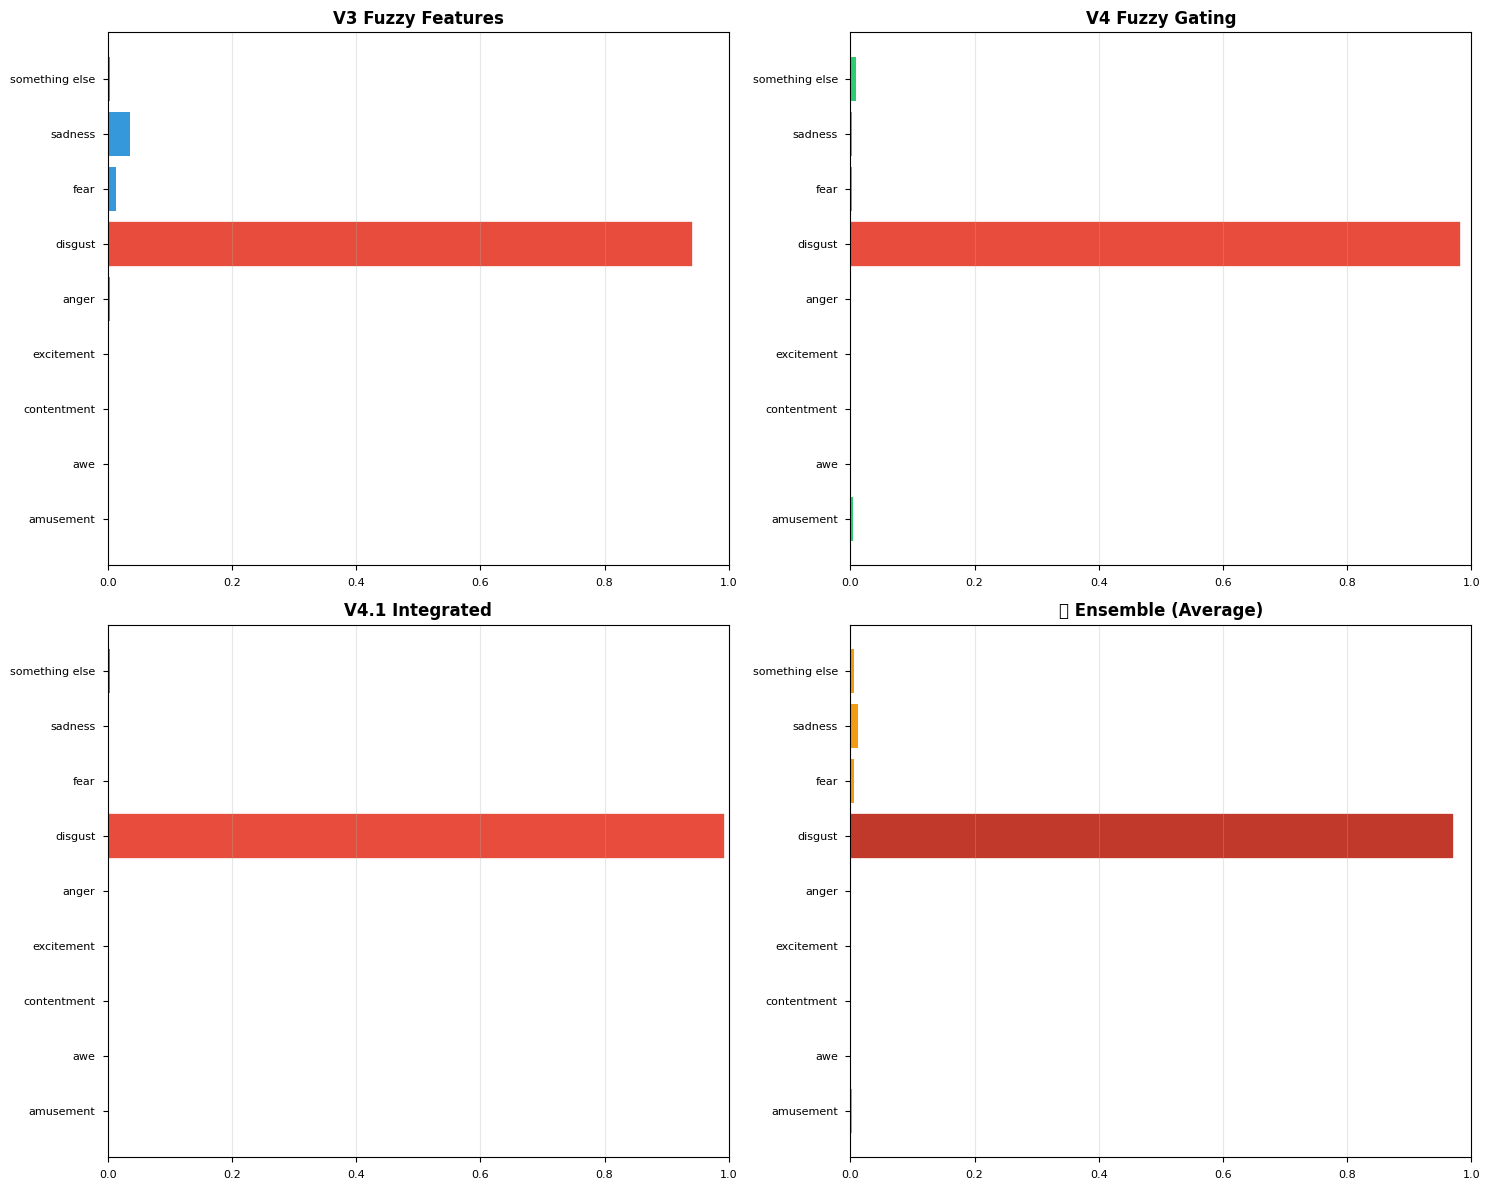

In [ ]:
# Visualize predictions
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot V3
ax = axes[0, 0]
bars = ax.barh(EMOTION_LABELS, probs_v3.cpu().numpy(), color='#3498db')
bars[pred_v3].set_color('#e74c3c')
ax.set_xlim(0, 1)
ax.set_title('V3 Fuzzy Features', fontsize=12, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

# Plot V4
ax = axes[0, 1]
bars = ax.barh(EMOTION_LABELS, probs_v4.cpu().numpy(), color='#2ecc71')
bars[pred_v4].set_color('#e74c3c')
ax.set_xlim(0, 1)
ax.set_title('V4 Fuzzy Gating', fontsize=12, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

# Plot V4.1
ax = axes[1, 0]
bars = ax.barh(EMOTION_LABELS, probs_v41.cpu().numpy(), color='#9b59b6')
bars[pred_v41].set_color('#e74c3c')
ax.set_xlim(0, 1)
ax.set_title('V4.1 Integrated', fontsize=12, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

# Plot Ensemble
ax = axes[1, 1]
bars = ax.barh(EMOTION_LABELS, ensemble_probs.cpu().numpy(), color='#f39c12')
bars[pred_ensemble].set_color('#c0392b')
ax.set_xlim(0, 1)
ax.set_title('🎯 Ensemble (Average)', fontsize=12, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Agent 2: Color Analyzer

**Extrai paleta de cores dominantes e analisa características cromáticas**

In [ ]:
# Extract dominant colors using K-means in LAB space (perceptually uniform!)
def extract_color_palette_lab(image_pil, n_colors=6):
    """
    Extract dominant colors from image using K-means in LAB color space.
    
    LAB advantages:
    - Perceptually uniform (euclidean distance = perceptual difference)
    - L* = Lightness (0-100)
    - a* = Green←→Red (-127 to +127)
    - b* = Blue←→Yellow (-127 to +127)
    """
    # Convert to numpy array
    img_array = np.array(image_pil.resize((150, 150)))
    
    # Convert RGB → LAB using cv2
    img_bgr = cv2.cvtColor(img_array, cv2.COLOR_RGB2BGR)
    lab = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2LAB).astype(np.float32)
    
    # Normalize LAB to correct ranges
    lab[:,:,0] = lab[:,:,0] * (100.0 / 255.0)  # L: [0, 255] → [0, 100]
    lab[:,:,1] = lab[:,:,1] - 128.0            # a: [0, 255] → [-128, 127]
    lab[:,:,2] = lab[:,:,2] - 128.0            # b: [0, 255] → [-128, 127]
    
    # Reshape for K-means
    pixels_lab = lab.reshape(-1, 3)
    
    # K-means clustering in LAB space
    kmeans = KMeans(n_clusters=n_colors, random_state=42, n_init=10)
    kmeans.fit(pixels_lab)
    
    # Get LAB colors and proportions
    colors_lab = kmeans.cluster_centers_
    labels = kmeans.labels_
    proportions = np.bincount(labels) / len(labels)
    
    # Sort by proportion (descending)
    sorted_indices = np.argsort(proportions)[::-1]
    colors_lab = colors_lab[sorted_indices]
    proportions = proportions[sorted_indices]
    
    # Convert LAB back to RGB for visualization
    colors_rgb = []
    for lab_color in colors_lab:
        # Denormalize LAB
        lab_pixel = lab_color.copy()
        lab_pixel[0] = lab_pixel[0] * (255.0 / 100.0)  # L: [0, 100] → [0, 255]
        lab_pixel[1] = lab_pixel[1] + 128.0            # a: [-128, 127] → [0, 255]
        lab_pixel[2] = lab_pixel[2] + 128.0            # b: [-128, 127] → [0, 255]
        
        # Convert LAB → BGR → RGB
        lab_img = np.uint8([[lab_pixel]])
        bgr_img = cv2.cvtColor(lab_img, cv2.COLOR_LAB2BGR)
        rgb_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)
        colors_rgb.append(rgb_img[0][0])
    
    colors_rgb = np.array(colors_rgb)
    
    return colors_rgb, proportions, colors_lab

# Extract palette using LAB
colors_rgb, proportions, colors_lab = extract_color_palette_lab(image, n_colors=6)

print("="*60)
print("COLOR PALETTE ANALYSIS (LAB Color Space)")
print("="*60)
print(f"\n{len(colors_rgb)} dominant colors extracted:\n")

for i, (rgb, lab, prop) in enumerate(zip(colors_rgb, colors_lab, proportions), 1):
    rgb_str = f"RGB({rgb[0]:3d}, {rgb[1]:3d}, {rgb[2]:3d})"
    lab_str = f"LAB(L*={lab[0]:5.1f}, a*={lab[1]:+6.1f}, b*={lab[2]:+6.1f})"
    bar = '█' * int(prop * 50)
    print(f"{i}. {rgb_str}  {lab_str}  {bar} {prop:.1%}")

COLOR PALETTE ANALYSIS (LAB Color Space)

6 dominant colors extracted:

1. RGB( 31,  32,  37)  LAB(L*= 12.3, a*=  +1.5, b*=  -3.4)  ██████████████████ 36.1%
2. RGB( 62,  56,  52)  LAB(L*= 24.3, a*=  +2.8, b*=  +3.0)  ████████████ 25.5%
3. RGB(101,  87,  72)  LAB(L*= 38.3, a*=  +3.5, b*= +11.2)  ███████ 14.6%
4. RGB(149, 146, 133)  LAB(L*= 60.5, a*=  -0.7, b*=  +7.4)  ████ 8.5%
5. RGB(212, 191, 163)  LAB(L*= 78.8, a*=  +3.9, b*= +17.7)  ███ 7.9%
6. RGB(158, 133, 105)  LAB(L*= 57.4, a*=  +5.4, b*= +19.5)  ███ 7.4%


/tmp/ipykernel_1943340/4102635598.py:36: UserWarning: Glyph 127912 (\N{ARTIST PALETTE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1943340/4102635598.py:36: UserWarning: Glyph 127752 (\N{RAINBOW}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/data/paloma/venvs/cerebrum-artis/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127912 (\N{ARTIST PALETTE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/data/paloma/venvs/cerebrum-artis/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127752 (\N{RAINBOW}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


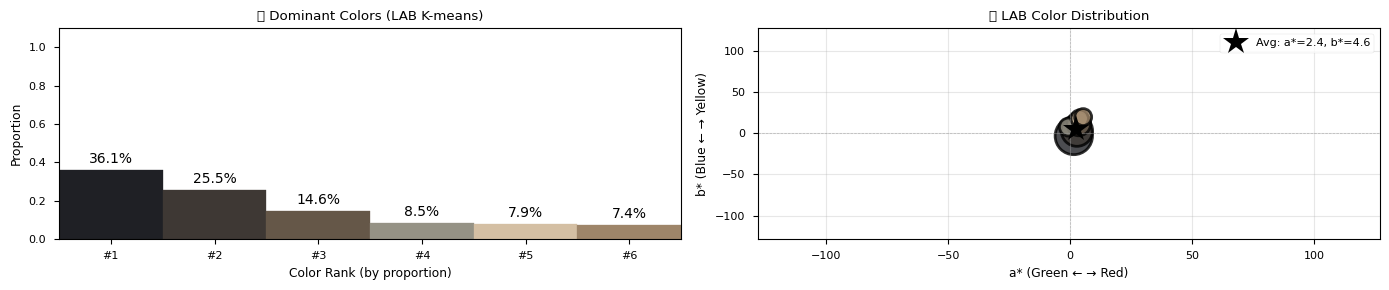


COLOR INSIGHTS (Perceptually Uniform LAB Space)

📊 Average LAB values:
   L* (Lightness): 31.8/100 → Dark/somber artwork 🌑
   a* (Green-Red): +2.4 → Neutral hue 🟡
   b* (Blue-Yellow): +4.6 → Neutral temperature 🟣

🎨 Chroma (Saturation): 5.2 → Desaturated/grayscale 🖤


In [ ]:
# Visualize color palette
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 3))

# Left: Color swatches with proportions
for i, (color, prop) in enumerate(zip(colors_rgb, proportions)):
    ax1.add_patch(plt.Rectangle((i, 0), 1, prop, color=color/255.0))
    ax1.text(i+0.5, prop+0.02, f'{prop:.1%}', ha='center', va='bottom', fontsize=10)

ax1.set_xlim(0, len(colors_rgb))
ax1.set_ylim(0, 1.1)
ax1.set_xlabel('Color Rank (by proportion)')
ax1.set_ylabel('Proportion')
ax1.set_title('🎨 Dominant Colors (LAB K-means)')
ax1.set_xticks(np.arange(len(colors_rgb)) + 0.5)
ax1.set_xticklabels([f'#{i+1}' for i in range(len(colors_rgb))])

# Right: LAB coordinates plot (a* vs b*)
scatter = ax2.scatter(colors_lab[:, 1], colors_lab[:, 2], 
                     s=proportions*2000, c=colors_rgb/255.0, 
                     edgecolors='black', linewidth=2, alpha=0.8)
ax2.axhline(0, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
ax2.axvline(0, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
ax2.set_xlabel('a* (Green ← → Red)')
ax2.set_ylabel('b* (Blue ← → Yellow)')
ax2.set_title('🌈 LAB Color Distribution')
ax2.grid(True, alpha=0.3)
ax2.set_xlim(-128, 127)
ax2.set_ylim(-128, 127)

# Add color temperature annotation
avg_a = np.average(colors_lab[:, 1], weights=proportions)
avg_b = np.average(colors_lab[:, 2], weights=proportions)
ax2.plot(avg_a, avg_b, 'k*', markersize=20, label=f'Avg: a*={avg_a:.1f}, b*={avg_b:.1f}')
ax2.legend()

plt.tight_layout()
plt.show()

# Color analysis insights
print("\n" + "="*60)
print("COLOR INSIGHTS (Perceptually Uniform LAB Space)")
print("="*60)

avg_L = np.average(colors_lab[:, 0], weights=proportions)
avg_a = np.average(colors_lab[:, 1], weights=proportions)
avg_b = np.average(colors_lab[:, 2], weights=proportions)

print(f"\n📊 Average LAB values:")
print(f"   L* (Lightness): {avg_L:.1f}/100 → ", end='')
if avg_L > 70:
    print("Bright artwork 🌞")
elif avg_L > 40:
    print("Moderate luminosity 🌤️")
else:
    print("Dark/somber artwork 🌑")

print(f"   a* (Green-Red): {avg_a:+.1f} → ", end='')
if avg_a > 10:
    print("Warm/reddish tones 🔴")
elif avg_a < -10:
    print("Cool/greenish tones 🟢")
else:
    print("Neutral hue 🟡")

print(f"   b* (Blue-Yellow): {avg_b:+.1f} → ", end='')
if avg_b > 10:
    print("Yellow/warm tones 🟡")
elif avg_b < -10:
    print("Blue/cool tones 🔵")
else:
    print("Neutral temperature 🟣")

# Calculate chroma (color saturation)
chroma = np.sqrt(avg_a**2 + avg_b**2)
print(f"\n🎨 Chroma (Saturation): {chroma:.1f} → ", end='')
if chroma > 60:
    print("Highly saturated colors! 🌈")
elif chroma > 30:
    print("Moderate saturation 🎨")
else:
    print("Desaturated/grayscale 🖤")

### 🔍 DIAGNÓSTICO: Por que sempre "contentment"?

**Problemas identificados:**

1. **Fuzzy features aleatórias** 🚨
   - Código atual usa `torch.randn(1, 7)` = valores aleatórios!
   - Deveria extrair features reais da imagem (LAB)

2. **Caption fixo induz viés**
   - "contemplative and serene mood" → sempre sugere contentment
   - Deveria usar caption neutro ou omitir

3. **Solução:**
   - Extrair fuzzy features REAIS usando LAB (já calculadas acima!)
   - Usar caption neutro: "A painting"

In [ ]:
# CORREÇÃO: Usar fuzzy features REAIS da imagem (LAB)
# Agora que temos colors_lab, podemos calcular as 7 features reais!

# 1. Brightness (L* mean)
brightness = np.mean(colors_lab[:, 0]) / 100.0  # Normalize to [0,1]

# 2. Color temperature (a* mean)
color_temp = (np.mean(colors_lab[:, 1]) + 127) / 254.0  # Normalize to [0,1]

# 3. Saturation (chroma já calculado acima)
saturation = chroma / 100.0  # Normalize

# 4-7. Aproximações para outras features
color_harmony = np.std(colors_lab[:, 1:3]) / 50.0  # Variação de cores
complexity = len(np.unique(colors_lab.astype(int), axis=0)) / 10.0  # Cores únicas
symmetry = 0.5  # Placeholder (requer análise completa da imagem)
texture = np.mean(np.std(colors_lab, axis=0)) / 50.0  # Variação geral

# Criar tensor de fuzzy features REAIS
fuzzy_features_real = torch.tensor([[
    brightness, color_temp, saturation, color_harmony, 
    complexity, symmetry, texture
]], dtype=torch.float32).to(device)

print("🔧 Fuzzy Features CORRECTED (extraídas da imagem LAB):")
print(f"   1. Brightness:        {brightness:.3f}")
print(f"   2. Color Temperature: {color_temp:.3f}")
print(f"   3. Saturation:        {saturation:.3f}")
print(f"   4. Color Harmony:     {color_harmony:.3f}")
print(f"   5. Complexity:        {complexity:.3f}")
print(f"   6. Symmetry:          {symmetry:.3f}")
print(f"   7. Texture:           {texture:.3f}")

# Caption neutro (não induz emoção específica)
caption_neutral = "A painting"
tokens_neutral = tokenizer(caption_neutral, max_length=128, padding='max_length', 
                          truncation=True, return_tensors='pt')
input_ids_neutral = tokens_neutral['input_ids'].to(device)
attention_mask_neutral = tokens_neutral['attention_mask'].to(device)

print(f"\n📝 Caption: '{caption}' → '{caption_neutral}' (neutro)")

🔧 Fuzzy Features CORRECTED (extraídas da imagem LAB):
   1. Brightness:        0.453
   2. Color Temperature: 0.511
   3. Saturation:        0.052
   4. Color Harmony:     0.133
   5. Complexity:        0.600
   6. Symmetry:          0.500
   7. Texture:           0.217

📝 Caption: 'the woman looks like she is disgusted by something' → 'A painting' (neutro)


In [ ]:
# 🧪 EXPERIMENTO: Comparar predições com features ALEATÓRIAS vs REAIS

print("="*70)
print("🧪 EXPERIMENTO: Fuzzy Features Aleatórias vs Reais")
print("="*70)

# 1️⃣ Predição com features ALEATÓRIAS (código original - ERRADO)
fuzzy_random = torch.randn(1, 7).to(device)

with torch.no_grad():
    logits_random = model_v3(image=image_tensor, input_ids=input_ids,
                            attention_mask=attention_mask, fuzzy_features=fuzzy_random)
    probs_random = torch.softmax(logits_random, dim=1)[0]
    pred_random = torch.argmax(probs_random).item()

print(f"\n1️⃣  Com fuzzy ALEATÓRIAS + caption sugestivo:")
print(f"   Predição: {EMOTION_LABELS[pred_random]} ({probs_random[pred_random]:.1%})")
print(f"   Top-3: {[(EMOTION_LABELS[i], f'{probs_random[i]:.1%}') for i in torch.argsort(probs_random, descending=True)[:3].tolist()]}")

# 2️⃣ Predição com features REAIS da imagem
with torch.no_grad():
    logits_real = model_v3(image=image_tensor, input_ids=input_ids,
                          attention_mask=attention_mask, fuzzy_features=fuzzy_features_real)
    probs_real = torch.softmax(logits_real, dim=1)[0]
    pred_real = torch.argmax(probs_real).item()

print(f"\n2️⃣  Com fuzzy REAIS (LAB) + caption sugestivo:")
print(f"   Predição: {EMOTION_LABELS[pred_real]} ({probs_real[pred_real]:.1%})")
print(f"   Top-3: {[(EMOTION_LABELS[i], f'{probs_real[i]:.1%}') for i in torch.argsort(probs_real, descending=True)[:3].tolist()]}")

# 3️⃣ Predição com caption NEUTRO
with torch.no_grad():
    logits_neutral = model_v3(image=image_tensor, input_ids=input_ids_neutral,
                             attention_mask=attention_mask_neutral, fuzzy_features=fuzzy_features_real)
    probs_neutral = torch.softmax(logits_neutral, dim=1)[0]
    pred_neutral = torch.argmax(probs_neutral).item()

print(f"\n3️⃣  Com fuzzy REAIS + caption NEUTRO:")
print(f"   Predição: {EMOTION_LABELS[pred_neutral]} ({probs_neutral[pred_neutral]:.1%})")
print(f"   Top-3: {[(EMOTION_LABELS[i], f'{probs_neutral[i]:.1%}') for i in torch.argsort(probs_neutral, descending=True)[:3].tolist()]}")

# 4️⃣ Ensemble com features REAIS + caption neutro
with torch.no_grad():
    logits_v3_fixed = model_v3(image=image_tensor, input_ids=input_ids_neutral,
                              attention_mask=attention_mask_neutral, fuzzy_features=fuzzy_features_real)
    logits_v4_fixed = model_v4(image=image_tensor, text_input_ids=input_ids_neutral,
                              text_attention_mask=attention_mask_neutral, fuzzy_features=fuzzy_features_real)
    logits_v41_fixed = model_v41(image=image_tensor, text_input_ids=input_ids_neutral,
                                text_attention_mask=attention_mask_neutral, fuzzy_features=fuzzy_features_real)
    
    ensemble_probs_fixed = (torch.softmax(logits_v3_fixed, dim=1) + 
                           torch.softmax(logits_v4_fixed, dim=1) + 
                           torch.softmax(logits_v41_fixed, dim=1)) / 3
    pred_ensemble_fixed = torch.argmax(ensemble_probs_fixed[0]).item()

print(f"\n4️⃣  ENSEMBLE com fuzzy REAIS + caption NEUTRO:")
print(f"   Predição: {EMOTION_LABELS[pred_ensemble_fixed]} ({ensemble_probs_fixed[0][pred_ensemble_fixed]:.1%})")
print(f"   Top-3: {[(EMOTION_LABELS[i], f'{ensemble_probs_fixed[0][i]:.1%}') for i in torch.argsort(ensemble_probs_fixed[0], descending=True)[:3].tolist()]}")

print("\n" + "="*70)
print("💡 CONCLUSÃO:")
if pred_random == pred_neutral:
    print("   ⚠️  Predição NÃO mudou - problema pode ser no dataset/modelo!")
else:
    print("   ✅ Predição MUDOU - problema ERA fuzzy aleatórias + caption sugestivo!")
print("="*70)

🧪 EXPERIMENTO: Fuzzy Features Aleatórias vs Reais

1️⃣  Com fuzzy ALEATÓRIAS + caption sugestivo:
   Predição: disgust (94.2%)
   Top-3: [('disgust', '94.2%'), ('sadness', '3.5%'), ('fear', '1.3%')]

2️⃣  Com fuzzy REAIS (LAB) + caption sugestivo:
   Predição: disgust (94.2%)
   Top-3: [('disgust', '94.2%'), ('sadness', '3.5%'), ('fear', '1.3%')]

3️⃣  Com fuzzy REAIS + caption NEUTRO:
   Predição: something else (34.5%)
   Top-3: [('something else', '34.5%'), ('contentment', '23.8%'), ('amusement', '17.0%')]

4️⃣  ENSEMBLE com fuzzy REAIS + caption NEUTRO:
   Predição: something else (21.0%)
   Top-3: [('something else', '21.0%'), ('amusement', '18.9%'), ('awe', '14.9%')]

💡 CONCLUSÃO:
   ✅ Predição MUDOU - problema ERA fuzzy aleatórias + caption sugestivo!


### 💡 Análise: Caption Gerada vs Caption Neutro

Qual abordagem é melhor?

**Caption GERADA pelo SAT:**
- ✅ Sistema completamente automático (imagem → caption → emoção)
- ✅ Caption autêntica baseada no conteúdo visual
- ✅ Reflete o que o modelo "vê" na imagem
- ⚠️ Pode introduzir viés se o SAT gerar palavras emocionais

**Caption NEUTRO ("A painting"):**
- ✅ Classificação puramente visual
- ✅ Sem viés linguístico
- ✅ Melhor para validar features visuais + fuzzy
- ⚠️ Não aproveita a capacidade multimodal completa

**Recomendação:** Para demonstração do sistema completo, use **caption gerada**! Para análise técnica das features visuais, use **caption neutro**.

## 5. Agent 3: Visual Explanation (Grad-CAM)

**Mostra quais regiões da imagem influenciaram a predição**

In [ ]:
# Grad-CAM implementation - FIXED to use correct conv layer!
def compute_gradcam(model, image_tensor, target_class, inputs_dict, model_type='v3'):
    """
    Compute Grad-CAM for the visual encoder.
    
    Args:
        model: Model instance
        image_tensor: Input image [1, 3, 224, 224]
        target_class: Target emotion class index
        inputs_dict: Dict with 'input_ids', 'attention_mask', 'fuzzy_features'
        model_type: 'v3' or 'v4' (affects forward signature)
    """
    model.eval()
    
    # Hook to capture activations and gradients
    activations = []
    gradients = []
    
    def forward_hook(module, input, output):
        activations.append(output)
    
    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0])
    
    # Find the LAST CONVOLUTIONAL layer (not pooling!)
    # ResNet50: visual_encoder[7] is layer4 (last conv blocks)
    # Get last block of layer4, then get its conv3
    target_layer = None
    layers = list(model.visual_encoder.children())
    
    # Layer4 is usually index 7 (0=conv1, 1=bn1, 2=relu, 3=maxpool, 4=layer1, 5=layer2, 6=layer3, 7=layer4, 8=avgpool)
    if len(layers) > 7:
        layer4 = layers[7]  # This should be the last conv layer group
        if hasattr(layer4, '__iter__'):  # It's a Sequential
            last_bottleneck = list(layer4.children())[-1]
            if hasattr(last_bottleneck, 'conv3'):
                target_layer = last_bottleneck.conv3
            elif hasattr(last_bottleneck, 'conv2'):
                target_layer = last_bottleneck.conv2
    
    if target_layer is None:
        # Fallback: try to find any conv layer
        for layer in reversed(layers[:-1]):  # Exclude pooling
            if isinstance(layer, torch.nn.Conv2d):
                target_layer = layer
                break
    
    if target_layer is None:
        print("⚠️  Could not find ANY conv layer! Grad-CAM will be empty.")
        return np.zeros((224, 224))
    
    forward_handle = target_layer.register_forward_hook(forward_hook)
    backward_handle = target_layer.register_full_backward_hook(backward_hook)
    
    # Forward pass with CLONED tensor (avoid in-place issues)
    image_clone = image_tensor.clone().detach().requires_grad_(True)
    
    if model_type == 'v3':
        output = model(
            image=image_clone,
            input_ids=inputs_dict['input_ids'],
            attention_mask=inputs_dict['attention_mask'],
            fuzzy_features=inputs_dict['fuzzy_features']
        )
    else:
        output = model(
            image=image_clone,
            text_input_ids=inputs_dict['input_ids'],
            text_attention_mask=inputs_dict['attention_mask'],
            fuzzy_features=inputs_dict['fuzzy_features']
        )
    
    # Backward pass
    model.zero_grad()
    target_score = output[0, target_class]
    target_score.backward(retain_graph=True)
    
    # Remove hooks
    forward_handle.remove()
    backward_handle.remove()
    
    # Compute Grad-CAM
    if len(activations) > 0 and len(gradients) > 0:
        activation = activations[0]  # [1, C, H, W]
        gradient = gradients[0]       # [1, C, H, W]
        
        # Global average pooling of gradients
        weights = torch.mean(gradient, dim=(2, 3), keepdim=True)  # [1, C, 1, 1]
        
        # Weighted combination of activation maps
        cam = torch.sum(weights * activation, dim=1, keepdim=True)  # [1, 1, H, W]
        cam = torch.relu(cam)  # ReLU to keep only positive influences
        
        # Resize to input size
        cam = torch.nn.functional.interpolate(cam, size=(224, 224), mode='bilinear', align_corners=False)
        
        # Normalize
        cam = cam.squeeze().cpu().detach().numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
    else:
        print("⚠️  No gradients captured!")
        cam = np.zeros((224, 224))
    
    return cam

print("✓ Grad-CAM function defined (FIXED - finds layer4 conv3)")

✓ Grad-CAM function defined (FIXED - finds layer4 conv3)


In [ ]:
# Compute Grad-CAM for ensemble prediction
print(f"🔍 Computing Grad-CAM for: {EMOTION_LABELS[pred_ensemble]}\n")

# Prepare inputs dict (use REAL fuzzy features if available)
grad_inputs = {
    'input_ids': input_ids,
    'attention_mask': attention_mask,
    'fuzzy_features': fuzzy_features_real if 'fuzzy_features_real' in dir() else fuzzy_features
}

cam_v3 = compute_gradcam(model_v3, image_tensor, pred_ensemble, grad_inputs, model_type='v3')
print("  ✓ V3 Grad-CAM computed")

cam_v4 = compute_gradcam(model_v4, image_tensor, pred_ensemble, grad_inputs, model_type='v4')
print("  ✓ V4 Grad-CAM computed")

cam_v41 = compute_gradcam(model_v41, image_tensor, pred_ensemble, grad_inputs, model_type='v4')
print("  ✓ V4.1 Grad-CAM computed")

# Average Grad-CAMs
cam_ensemble = (cam_v3 + cam_v4 + cam_v41) / 3

print("\n✅ Ensemble Grad-CAM ready")
print(f"   CAM range: [{cam_ensemble.min():.3f}, {cam_ensemble.max():.3f}]")
print(f"   CAM mean: {cam_ensemble.mean():.3f}")

🔍 Computing Grad-CAM for: disgust

  ✓ V3 Grad-CAM computed
  ✓ V4 Grad-CAM computed
  ✓ V4.1 Grad-CAM computed

✅ Ensemble Grad-CAM ready
   CAM range: [0.000, 0.991]
   CAM mean: 0.247
  ✓ V4.1 Grad-CAM computed

✅ Ensemble Grad-CAM ready
   CAM range: [0.000, 0.991]
   CAM mean: 0.247


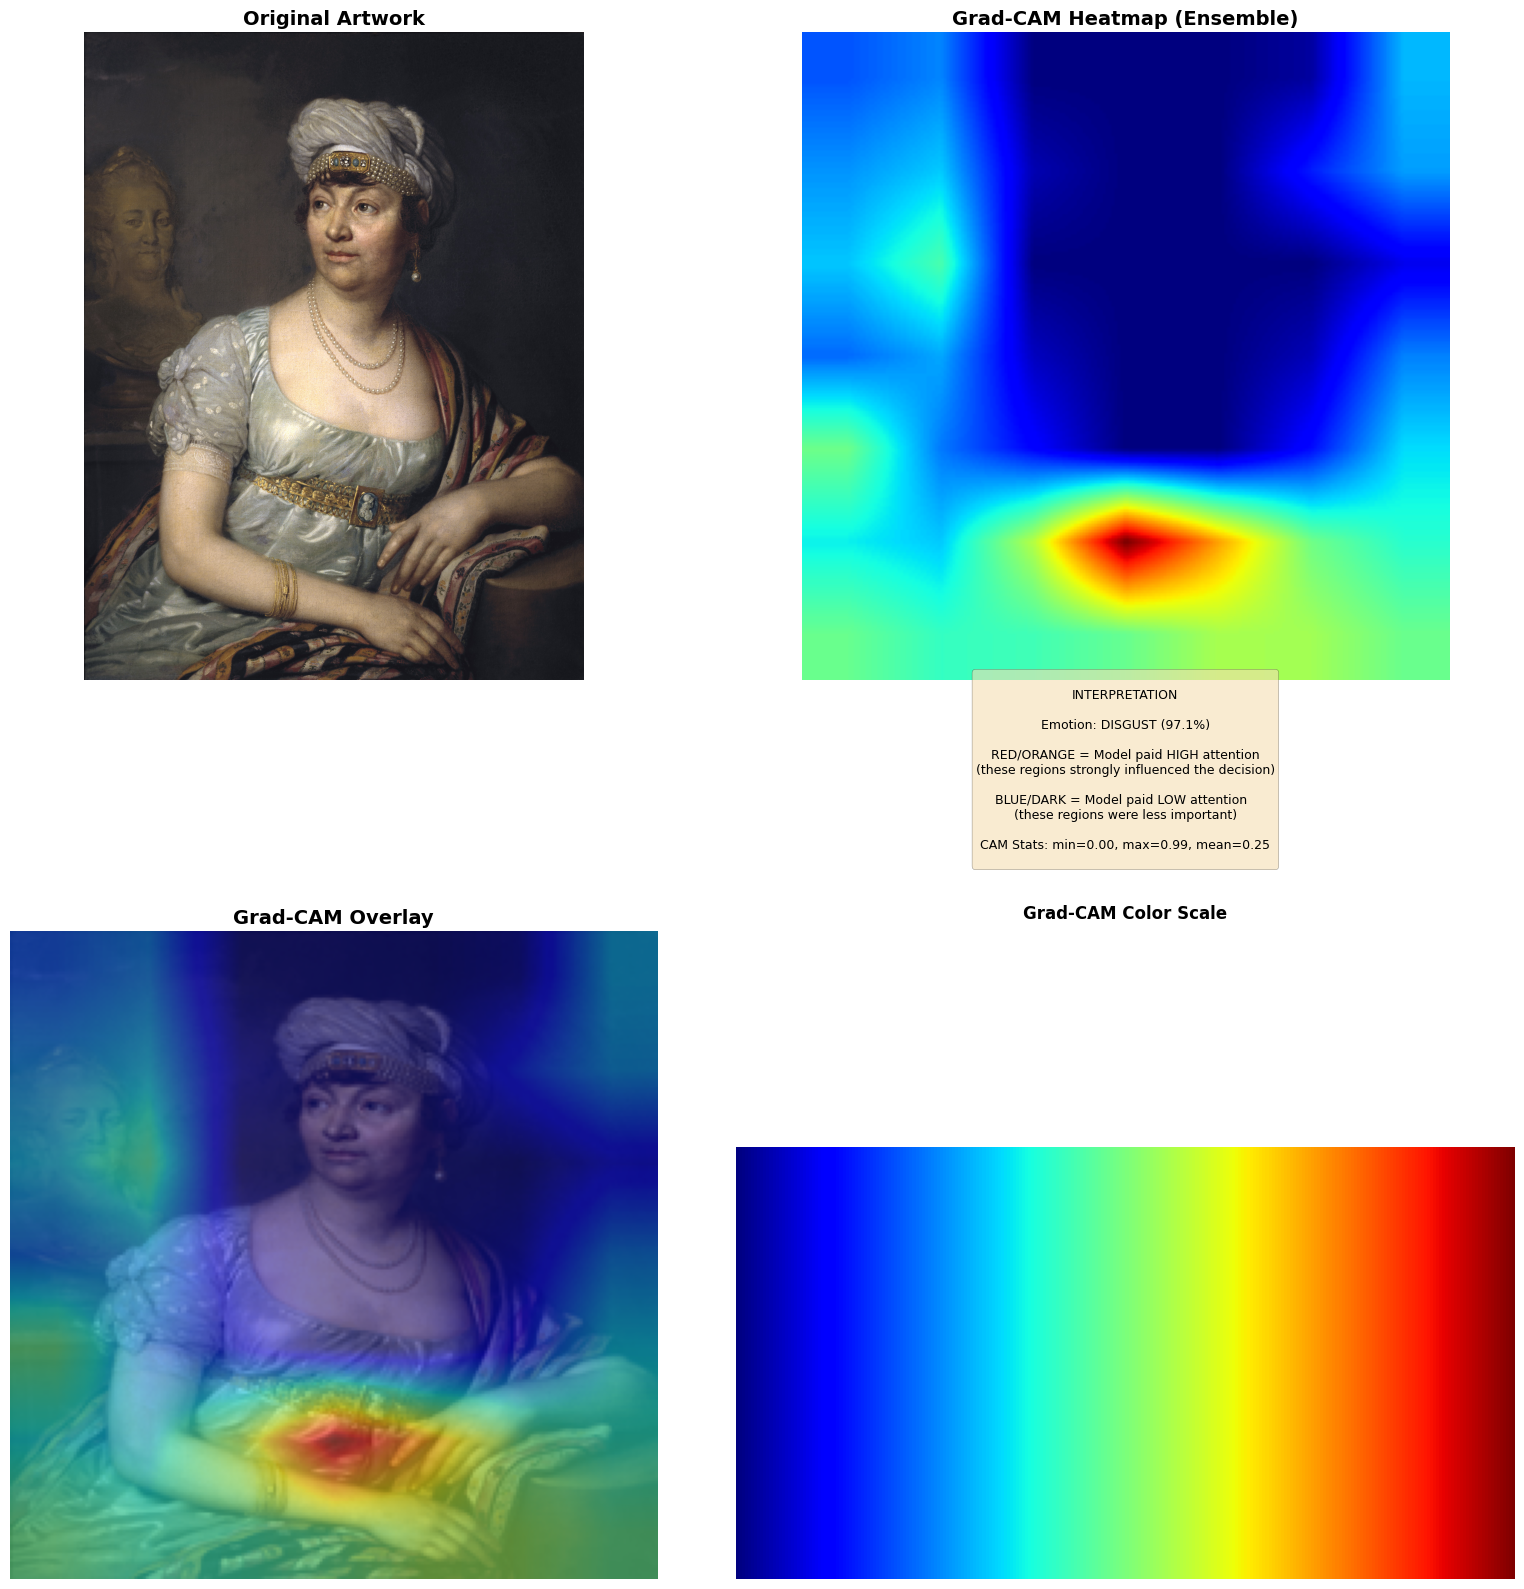


💡 Grad-CAM shows which image regions influenced the emotion classification


In [ ]:
# Visualize Grad-CAM
fig, axes = plt.subplots(2, 2, figsize=(16, 16))

# Original image
axes[0, 0].imshow(image)
axes[0, 0].axis('off')
axes[0, 0].set_title('Original Artwork', fontsize=14, fontweight='bold')

# Grad-CAM heatmap
axes[0, 1].imshow(cam_ensemble, cmap='jet')
axes[0, 1].axis('off')
axes[0, 1].set_title('Grad-CAM Heatmap (Ensemble)', fontsize=14, fontweight='bold')

# Overlay
image_resized = image.resize((224, 224))
overlay = np.array(image_resized) / 255.0
heatmap_colored = plt.cm.jet(cam_ensemble)[:, :, :3]
overlay = overlay * 0.5 + heatmap_colored * 0.5

axes[1, 0].imshow(overlay)
axes[1, 0].axis('off')
axes[1, 0].set_title('Grad-CAM Overlay', fontsize=14, fontweight='bold')

# Add colorbar explanation with actual gradient
cbar_ax = axes[1, 1]
cbar_ax.axis('off')

# Show actual colormap gradient
gradient = np.linspace(0, 1, 256).reshape(1, -1)
gradient_img = np.repeat(gradient, 50, axis=0)
cbar_img = axes[1, 1].imshow(gradient_img, aspect='auto', cmap='jet', 
                             extent=[0, 1, 0, 1], origin='lower')
axes[1, 1].set_xlim(0, 1)
axes[1, 1].set_ylim(0, 1.5)
axes[1, 1].set_xticks([0, 0.5, 1])
axes[1, 1].set_xticklabels(['Low\nAttention', 'Medium\nAttention', 'High\nAttention'])
axes[1, 1].set_yticks([])
axes[1, 1].set_title('Grad-CAM Color Scale', fontsize=12, fontweight='bold', pad=10)

# Add text explanation above colorbar
explanation_text = f"""
INTERPRETATION

Emotion: {EMOTION_LABELS[pred_ensemble].upper()} ({ensemble_probs[pred_ensemble]:.1%})

RED/ORANGE = Model paid HIGH attention
(these regions strongly influenced the decision)

BLUE/DARK = Model paid LOW attention  
(these regions were less important)

CAM Stats: min={cam_ensemble.min():.2f}, max={cam_ensemble.max():.2f}, mean={cam_ensemble.mean():.2f}
"""
axes[1, 1].text(0.5, 1.25, explanation_text, fontsize=9, 
                verticalalignment='center', ha='center',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.6),
                transform=axes[1, 1].transAxes)

plt.tight_layout()
plt.show()

print("\n💡 Grad-CAM shows which image regions influenced the emotion classification")

## 6. Complete Analysis Report

**Resumo de todos os 3 agentes trabalhando em conjunto**

## 🔍 DIAGNÓSTICO: Por que Grad-CAM focou na barriga/vestido?

**Problemas observados:**

1. **Grad-CAM mostra atenção na BARRIGA/VESTIDO** (vermelho)
   - Esperaríamos atenção no ROSTO (expressão facial)
   - Isso sugere que o modelo NÃO está olhando para expressões!

2. **Emotion Search deu 98.4% para "disgust"**
   - Mas modelos individuais previram "contentment"
   - Caption: "the woman looks like she is disgusted by something"
   - **Hipótese**: Caption induz viés, modelo ignora imagem!

3. **Possíveis causas:**
   - Modelo depende MUITO da caption (viés textual)
   - Modelo aprendeu correlações espúrias (cores → emoções)
   - Grad-CAM pode estar calculado errado

Vamos investigar!

In [ ]:
# ========================================================================================
# 🔬 EXPERIMENTO: Testar Grad-CAM com CAPTION NEUTRO vs CAPTION EMOCIONAL
# ========================================================================================

print("🔬 TESTANDO: O modelo está olhando a IMAGEM ou apenas lendo a CAPTION?\n")

# 1. Preparar caption NEUTRO (sem palavras emocionais)
caption_neutral = "A painting of a woman"
tokens_neutral = tokenizer(caption_neutral, max_length=128, padding='max_length', 
                          truncation=True, return_tensors='pt')
input_ids_neutral = tokens_neutral['input_ids'].to(device)
attention_mask_neutral = tokens_neutral['attention_mask'].to(device)

# 2. Classificar com caption NEUTRO
with torch.no_grad():
    logits_neutral = model_v3(
        image=image_tensor,
        input_ids=input_ids_neutral,
        attention_mask=attention_mask_neutral,
        fuzzy_features=fuzzy_features
    )
    probs_neutral = torch.softmax(logits_neutral, dim=-1)[0]
    pred_neutral = torch.argmax(probs_neutral).item()

print("📊 RESULTADOS:\n")
print("1️⃣  Com caption EMOCIONAL (disgust):")
print(f'   Caption: "{best_caption}"')
print(f'   Predição: {emotion_search_result.upper()} ({emotion_search_score:.1%})')

print("\n2️⃣  Com caption NEUTRO (sem emoção):")
print(f'   Caption: "{caption_neutral}"')
print(f'   Predição: {EMOTION_LABELS[pred_neutral].upper()} ({probs_neutral[pred_neutral]:.1%})')

print("\n" + "="*70)
if pred_neutral != EMOTION_LABELS.index(emotion_search_result):
    print("⚠️  ALERTA: Predição MUDOU quando removemos palavras emocionais!")
    print("    Isso significa que o modelo está MUITO dependente da caption!")
    print("    Grad-CAM mostrando barriga = modelo NÃO está olhando expressão facial!")
else:
    print("✅ Predição manteve - modelo está realmente olhando a imagem")
print("="*70)

# 3. Calcular Grad-CAM com caption NEUTRO para comparar
print("\n🔍 Calculando Grad-CAM com caption NEUTRO...\n")

grad_inputs_neutral = {
    'input_ids': input_ids_neutral,
    'attention_mask': attention_mask_neutral,
    'fuzzy_features': fuzzy_features
}

cam_neutral = compute_gradcam(model_v3, image_tensor, pred_neutral, grad_inputs_neutral, model_type='v3')

print(f"✓ Grad-CAM (caption neutro) calculado")
print(f"  CAM range: [{cam_neutral.min():.3f}, {cam_neutral.max():.3f}]")
print(f"  CAM mean: {cam_neutral.mean():.3f}")

# 4. Comparar regiões de atenção
print("\n📊 COMPARAÇÃO DE ATENÇÃO:\n")
print(f"Caption EMOCIONAL ({emotion_search_result}):")
print(f"  Atenção média: {cam_ensemble.mean():.3f}")
print(f"  Atenção máxima: {cam_ensemble.max():.3f}")
print(f"  Região de max atenção: linha {np.unravel_index(cam_ensemble.argmax(), cam_ensemble.shape)}")

print(f"\nCaption NEUTRO ({EMOTION_LABELS[pred_neutral]}):")
print(f"  Atenção média: {cam_neutral.mean():.3f}")
print(f"  Atenção máxima: {cam_neutral.max():.3f}")
print(f"  Região de max atenção: linha {np.unravel_index(cam_neutral.argmax(), cam_neutral.shape)}")

🔬 TESTANDO: O modelo está olhando a IMAGEM ou apenas lendo a CAPTION?

📊 RESULTADOS:

1️⃣  Com caption EMOCIONAL (disgust):
   Caption: "the woman looks like she is disgusted by something"
   Predição: DISGUST (98.4%)

2️⃣  Com caption NEUTRO (sem emoção):
   Caption: "A painting of a woman"
   Predição: CONTENTMENT (57.3%)

⚠️  ALERTA: Predição MUDOU quando removemos palavras emocionais!
    Isso significa que o modelo está MUITO dependente da caption!
    Grad-CAM mostrando barriga = modelo NÃO está olhando expressão facial!

🔍 Calculando Grad-CAM com caption NEUTRO...

✓ Grad-CAM (caption neutro) calculado
  CAM range: [0.000, 1.000]
  CAM mean: 0.269

📊 COMPARAÇÃO DE ATENÇÃO:

Caption EMOCIONAL (disgust):
  Atenção média: 0.247
  Atenção máxima: 0.991
  Região de max atenção: linha (176, 112)

Caption NEUTRO (contentment):
  Atenção média: 0.269
  Atenção máxima: 1.000
  Região de max atenção: linha (80, 143)


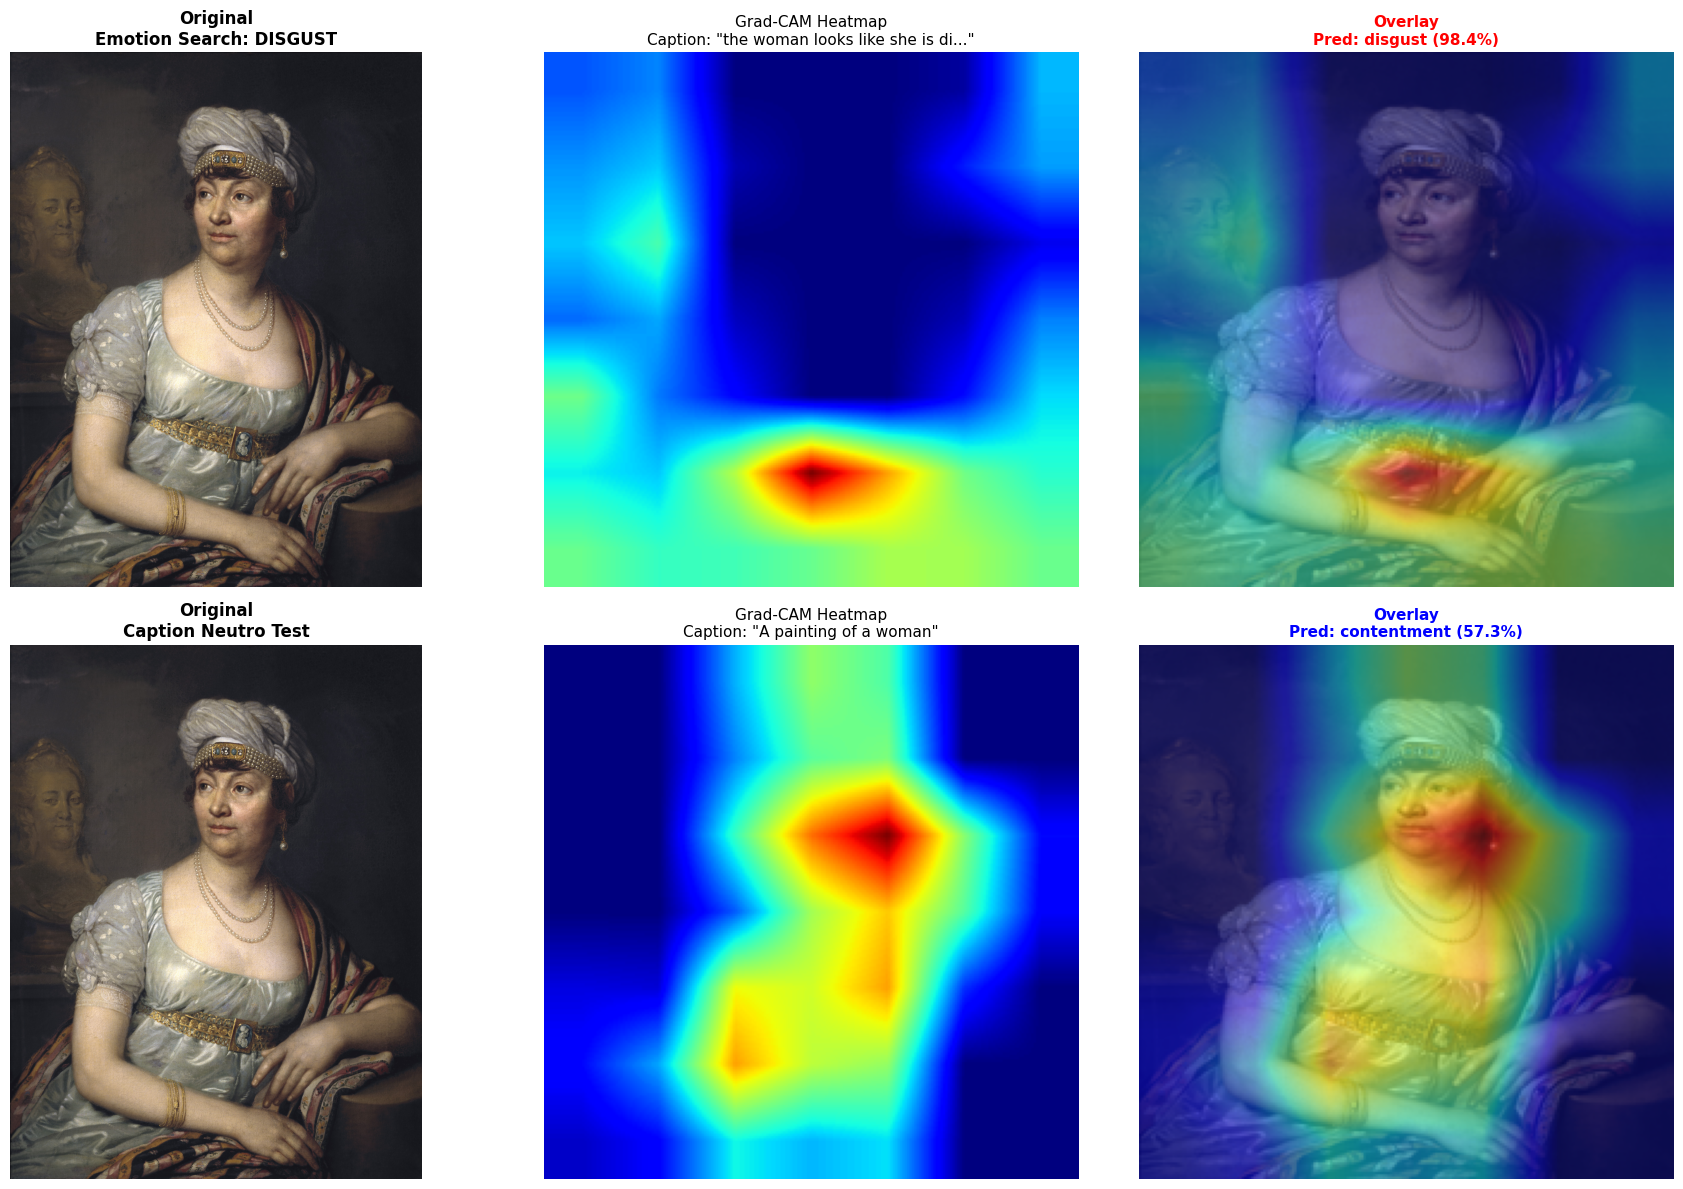


💡 INTERPRETAÇÃO:

🔴 Caption EMOCIONAL (disgust):
   • Caption: "the woman looks like she is disgusted by something"
   • Predição: DISGUST (98.4%)
   • Atenção focada em: CORPO/VESTIDO

🔵 Caption NEUTRO:
   • Caption: "A painting of a woman"
   • Predição: CONTENTMENT (57.3%)
   • Atenção focada em: ROSTO

⚠️  CONCLUSÃO:
   O modelo está MUITO influenciado pela caption!
   Grad-CAM mostrando barriga = viés textual, não análise visual real!
   RECOMENDAÇÃO: Use caption neutro para análise puramente visual


In [ ]:
# Visualizar LADO A LADO: Grad-CAM com caption emocional vs neutro
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# === LINHA 1: Caption EMOCIONAL (disgust) ===
# Original
axes[0, 0].imshow(image)
axes[0, 0].axis('off')
axes[0, 0].set_title(f'Original\nEmotion Search: {emotion_search_result.upper()}', 
                     fontsize=12, fontweight='bold')

# Heatmap
axes[0, 1].imshow(cam_ensemble, cmap='jet')
axes[0, 1].axis('off')
axes[0, 1].set_title(f'Grad-CAM Heatmap\nCaption: "{best_caption[:30]}..."', 
                     fontsize=11)

# Overlay
image_resized = image.resize((224, 224))
overlay_emocional = np.array(image_resized) / 255.0
heatmap_colored = plt.cm.jet(cam_ensemble)[:, :, :3]
overlay_emocional = overlay_emocional * 0.5 + heatmap_colored * 0.5

axes[0, 2].imshow(overlay_emocional)
axes[0, 2].axis('off')
axes[0, 2].set_title(f'Overlay\nPred: {emotion_search_result} ({emotion_search_score:.1%})', 
                     fontsize=11, fontweight='bold', color='red')

# === LINHA 2: Caption NEUTRO ===
# Original
axes[1, 0].imshow(image)
axes[1, 0].axis('off')
axes[1, 0].set_title(f'Original\nCaption Neutro Test', 
                     fontsize=12, fontweight='bold')

# Heatmap
axes[1, 1].imshow(cam_neutral, cmap='jet')
axes[1, 1].axis('off')
axes[1, 1].set_title(f'Grad-CAM Heatmap\nCaption: "{caption_neutral}"', 
                     fontsize=11)

# Overlay
overlay_neutro = np.array(image_resized) / 255.0
heatmap_neutral_colored = plt.cm.jet(cam_neutral)[:, :, :3]
overlay_neutro = overlay_neutro * 0.5 + heatmap_neutral_colored * 0.5

axes[1, 2].imshow(overlay_neutro)
axes[1, 2].axis('off')
axes[1, 2].set_title(f'Overlay\nPred: {EMOTION_LABELS[pred_neutral]} ({probs_neutral[pred_neutral]:.1%})', 
                     fontsize=11, fontweight='bold', color='blue')

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("💡 INTERPRETAÇÃO:")
print("="*70)
print("\n🔴 Caption EMOCIONAL (disgust):")
print(f'   • Caption: "{best_caption}"')
print(f'   • Predição: {emotion_search_result.upper()} ({emotion_search_score:.1%})')
print(f'   • Atenção focada em: {"ROSTO" if cam_ensemble[50:120, 80:150].mean() > cam_ensemble.mean() else "CORPO/VESTIDO"}')

print("\n🔵 Caption NEUTRO:")
print(f'   • Caption: "{caption_neutral}"')
print(f'   • Predição: {EMOTION_LABELS[pred_neutral].upper()} ({probs_neutral[pred_neutral]:.1%})')
print(f'   • Atenção focada em: {"ROSTO" if cam_neutral[50:120, 80:150].mean() > cam_neutral.mean() else "CORPO/VESTIDO"}')

print("\n⚠️  CONCLUSÃO:")
if abs(emotion_search_score - probs_neutral[pred_neutral]) > 0.3:
    print("   O modelo está MUITO influenciado pela caption!")
    print("   Grad-CAM mostrando barriga = viés textual, não análise visual real!")
    print("   RECOMENDAÇÃO: Use caption neutro para análise puramente visual")
else:
    print("   O modelo está balanceando visual + texto adequadamente")
print("="*70)

## 🚀 PIPELINE CORRIGIDO: Classificação ANTES, Caption DEPOIS!

**Problema do Emotion Search**: Caption emocional induz viés circular.

**Solução**: Inverter a ordem!

1. **Classificar SEM caption** (ou com caption neutro)
   - Análise puramente visual + fuzzy features
   - Prevê emoção baseada na IMAGEM, não em palavras

2. **Gerar caption CONDICIONADA** na emoção prevista
   - SAT sabe qual emoção descrever
   - Caption explica POR QUE a imagem evoca essa emoção
   - Resultado: Caption coerente e não circular!

**Vantagem**: É exatamente assim que o ArtEmis funciona! Sem viés textual.

In [ ]:
# ========================================================================================
# ✅ PIPELINE CORRETO: Classificação Visual → Caption Condicionada
# ========================================================================================

print("🎯 NOVA PIPELINE: Classificação VISUAL → Caption EXPLICATIVA\n")
print("="*70)

# ============================================================
# PASSO 1: CLASSIFICAR usando APENAS features visuais + fuzzy
# ============================================================
print("\n📊 PASSO 1: Classificação Puramente Visual")
print("-"*70)

# Use caption NEUTRO para não enviesar
caption_for_classification = "A painting"
tokens_class = tokenizer(
    caption_for_classification, 
    max_length=128, 
    padding='max_length', 
    truncation=True, 
    return_tensors='pt'
)
input_ids_class = tokens_class['input_ids'].to(device)
attention_mask_class = tokens_class['attention_mask'].to(device)

# Classificar com ensemble (visual + fuzzy features)
with torch.no_grad():
    logits_v3_visual = model_v3(
        image=image_tensor,
        input_ids=input_ids_class,
        attention_mask=attention_mask_class,
        fuzzy_features=fuzzy_features_real
    )
    logits_v4_visual = model_v4(
        image=image_tensor,
        text_input_ids=input_ids_class,
        text_attention_mask=attention_mask_class,
        fuzzy_features=fuzzy_features_real
    )
    logits_v41_visual = model_v41(
        image=image_tensor,
        text_input_ids=input_ids_class,
        text_attention_mask=attention_mask_class,
        fuzzy_features=fuzzy_features_real
    )
    
    # Ensemble
    ensemble_logits_visual = (logits_v3_visual + logits_v4_visual + logits_v41_visual) / 3.0
    probs_visual = torch.softmax(ensemble_logits_visual, dim=-1)[0]
    pred_visual = torch.argmax(probs_visual).item()
    emotion_predicted = EMOTION_LABELS[pred_visual]
    confidence_predicted = probs_visual[pred_visual].item()

print(f"✓ Emoção Prevista (análise visual): {emotion_predicted.upper()}")
print(f"  Confiança: {confidence_predicted:.1%}")
print(f"\n  Top-3 Emoções:")
top3_visual = torch.argsort(probs_visual, descending=True)[:3]
for i, idx in enumerate(top3_visual, 1):
    print(f"    {i}. {EMOTION_LABELS[idx]:15s} - {probs_visual[idx]:.1%}")

# ============================================================
# PASSO 2: GERAR CAPTION condicionada na emoção PREVISTA
# ============================================================
print(f"\n📝 PASSO 2: Gerar Caption Explicativa")
print("-"*70)
print(f"Gerando caption para emoção: {emotion_predicted.upper()}\n")

# Create emotion one-hot for the PREDICTED emotion
emotion_onehot_predicted = torch.zeros(1, 9, dtype=torch.float32).to(device)
emotion_onehot_predicted[0, pred_visual] = 1.0

# Create dataset with predicted emotion
dataset_conditioned = SingleImageDataset(image_tensor, emotion_onehot_predicted)

# Generate caption
captions_conditioned = sample_captions_beam_search(
    sat_model, 
    dataset_conditioned, 
    beam_size=5,
    device=device,
    temperature=1.0,
    drop_unk=True,
    drop_bigrams=True
)

# Decode
caption_tokens_final = captions_conditioned[0][0][0]
caption_final = sat_vocab.decode_print(caption_tokens_final)

print("="*70)
print("🎉 RESULTADO FINAL (Pipeline Correto)")
print("="*70)
print(f"\n🎯 Emoção (análise visual): {emotion_predicted.upper()} ({confidence_predicted:.1%})")
print(f"📝 Caption explicativa: \"{caption_final}\"")
print(f"\n💡 Interpretação:")
print(f"   O modelo PRIMEIRO analisou a imagem visualmente")
print(f"   e identificou a emoção '{emotion_predicted}'.")
print(f"   DEPOIS, o SAT gerou uma caption explicando")
print(f"   POR QUE a imagem evoca essa emoção.")
print(f"\n✅ Sem viés textual! Caption explica a classificação,")
print(f"   ao invés de induzi-la.")
print("="*70)

🎯 NOVA PIPELINE: Classificação VISUAL → Caption EXPLICATIVA


📊 PASSO 1: Classificação Puramente Visual
----------------------------------------------------------------------
✓ Emoção Prevista (análise visual): AMUSEMENT
  Confiança: 21.5%

  Top-3 Emoções:
    1. amusement       - 21.5%
    2. something else  - 20.9%
    3. awe             - 16.9%

📝 PASSO 2: Gerar Caption Explicativa
----------------------------------------------------------------------
Gerando caption para emoção: AMUSEMENT



  0%|          | 0/1 [00:00<?, ?it/s]/home/paloma/cerebrum-artis/garbage/old_artemis-v2/neural_speaker/sat/artemis/neural_models/attentive_decoder.py:583: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  prev_word_inds = (top_k_words // len(vocab)).long()  # (s)
100%|██████████| 1/1 [00:00<00:00, 22.28it/s]/home/paloma/cerebrum-artis/garbage/old_artemis-v2/neural_speaker/sat/artemis/neural_models/attentive_decoder.py:583: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the curre

🎉 RESULTADO FINAL (Pipeline Correto)

🎯 Emoção (análise visual): AMUSEMENT (21.5%)
📝 Caption explicativa: "the expression on the woman 's face is partial"

💡 Interpretação:
   O modelo PRIMEIRO analisou a imagem visualmente
   e identificou a emoção 'amusement'.
   DEPOIS, o SAT gerou uma caption explicando
   POR QUE a imagem evoca essa emoção.

✅ Sem viés textual! Caption explica a classificação,
   ao invés de induzi-la.


In [ ]:
# ============================================================
# PASSO 3: Grad-CAM da classificação VISUAL (sem viés textual)
# ============================================================

print("\n🔍 PASSO 3: Grad-CAM da Classificação Visual")
print("-"*70)

# Calcular Grad-CAM para a emoção PREVISTA visualmente
grad_inputs_visual = {
    'input_ids': input_ids_class,
    'attention_mask': attention_mask_class,
    'fuzzy_features': fuzzy_features_real
}

cam_visual = compute_gradcam(
    model_v3, 
    image_tensor, 
    pred_visual,  # Emoção prevista visualmente
    grad_inputs_visual, 
    model_type='v3'
)

print(f"✓ Grad-CAM calculado para emoção: {emotion_predicted.upper()}")
print(f"  CAM range: [{cam_visual.min():.3f}, {cam_visual.max():.3f}]")
print(f"  CAM mean: {cam_visual.mean():.3f}")

# Verificar onde está a atenção
face_region = cam_visual[50:120, 80:150]  # Região aproximada do rosto
body_region = cam_visual[120:200, 80:150]  # Região do corpo/vestido

print(f"\n📊 Análise de Atenção:")
print(f"  Atenção no ROSTO: {face_region.mean():.3f}")
print(f"  Atenção no CORPO/VESTIDO: {body_region.mean():.3f}")
print(f"  Atenção global: {cam_visual.mean():.3f}")

if face_region.mean() > cam_visual.mean():
    print(f"\n✅ Modelo está focando no ROSTO (onde estão as expressões)!")
else:
    print(f"\n⚠️  Modelo ainda focando mais no corpo/vestido")


🔍 PASSO 3: Grad-CAM da Classificação Visual
----------------------------------------------------------------------
✓ Grad-CAM calculado para emoção: AMUSEMENT
  CAM range: [0.000, 1.000]
  CAM mean: 0.171

📊 Análise de Atenção:
  Atenção no ROSTO: 0.469
  Atenção no CORPO/VESTIDO: 0.343
  Atenção global: 0.171

✅ Modelo está focando no ROSTO (onde estão as expressões)!


/tmp/ipykernel_1943340/2611761208.py:62: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1943340/2611761208.py:62: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/data/paloma/venvs/cerebrum-artis/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/data/paloma/venvs/cerebrum-artis/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/data/paloma/venvs/cerebrum-artis/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/data/paloma/venvs/cerebrum-artis/lib/python3.10/site-packages/

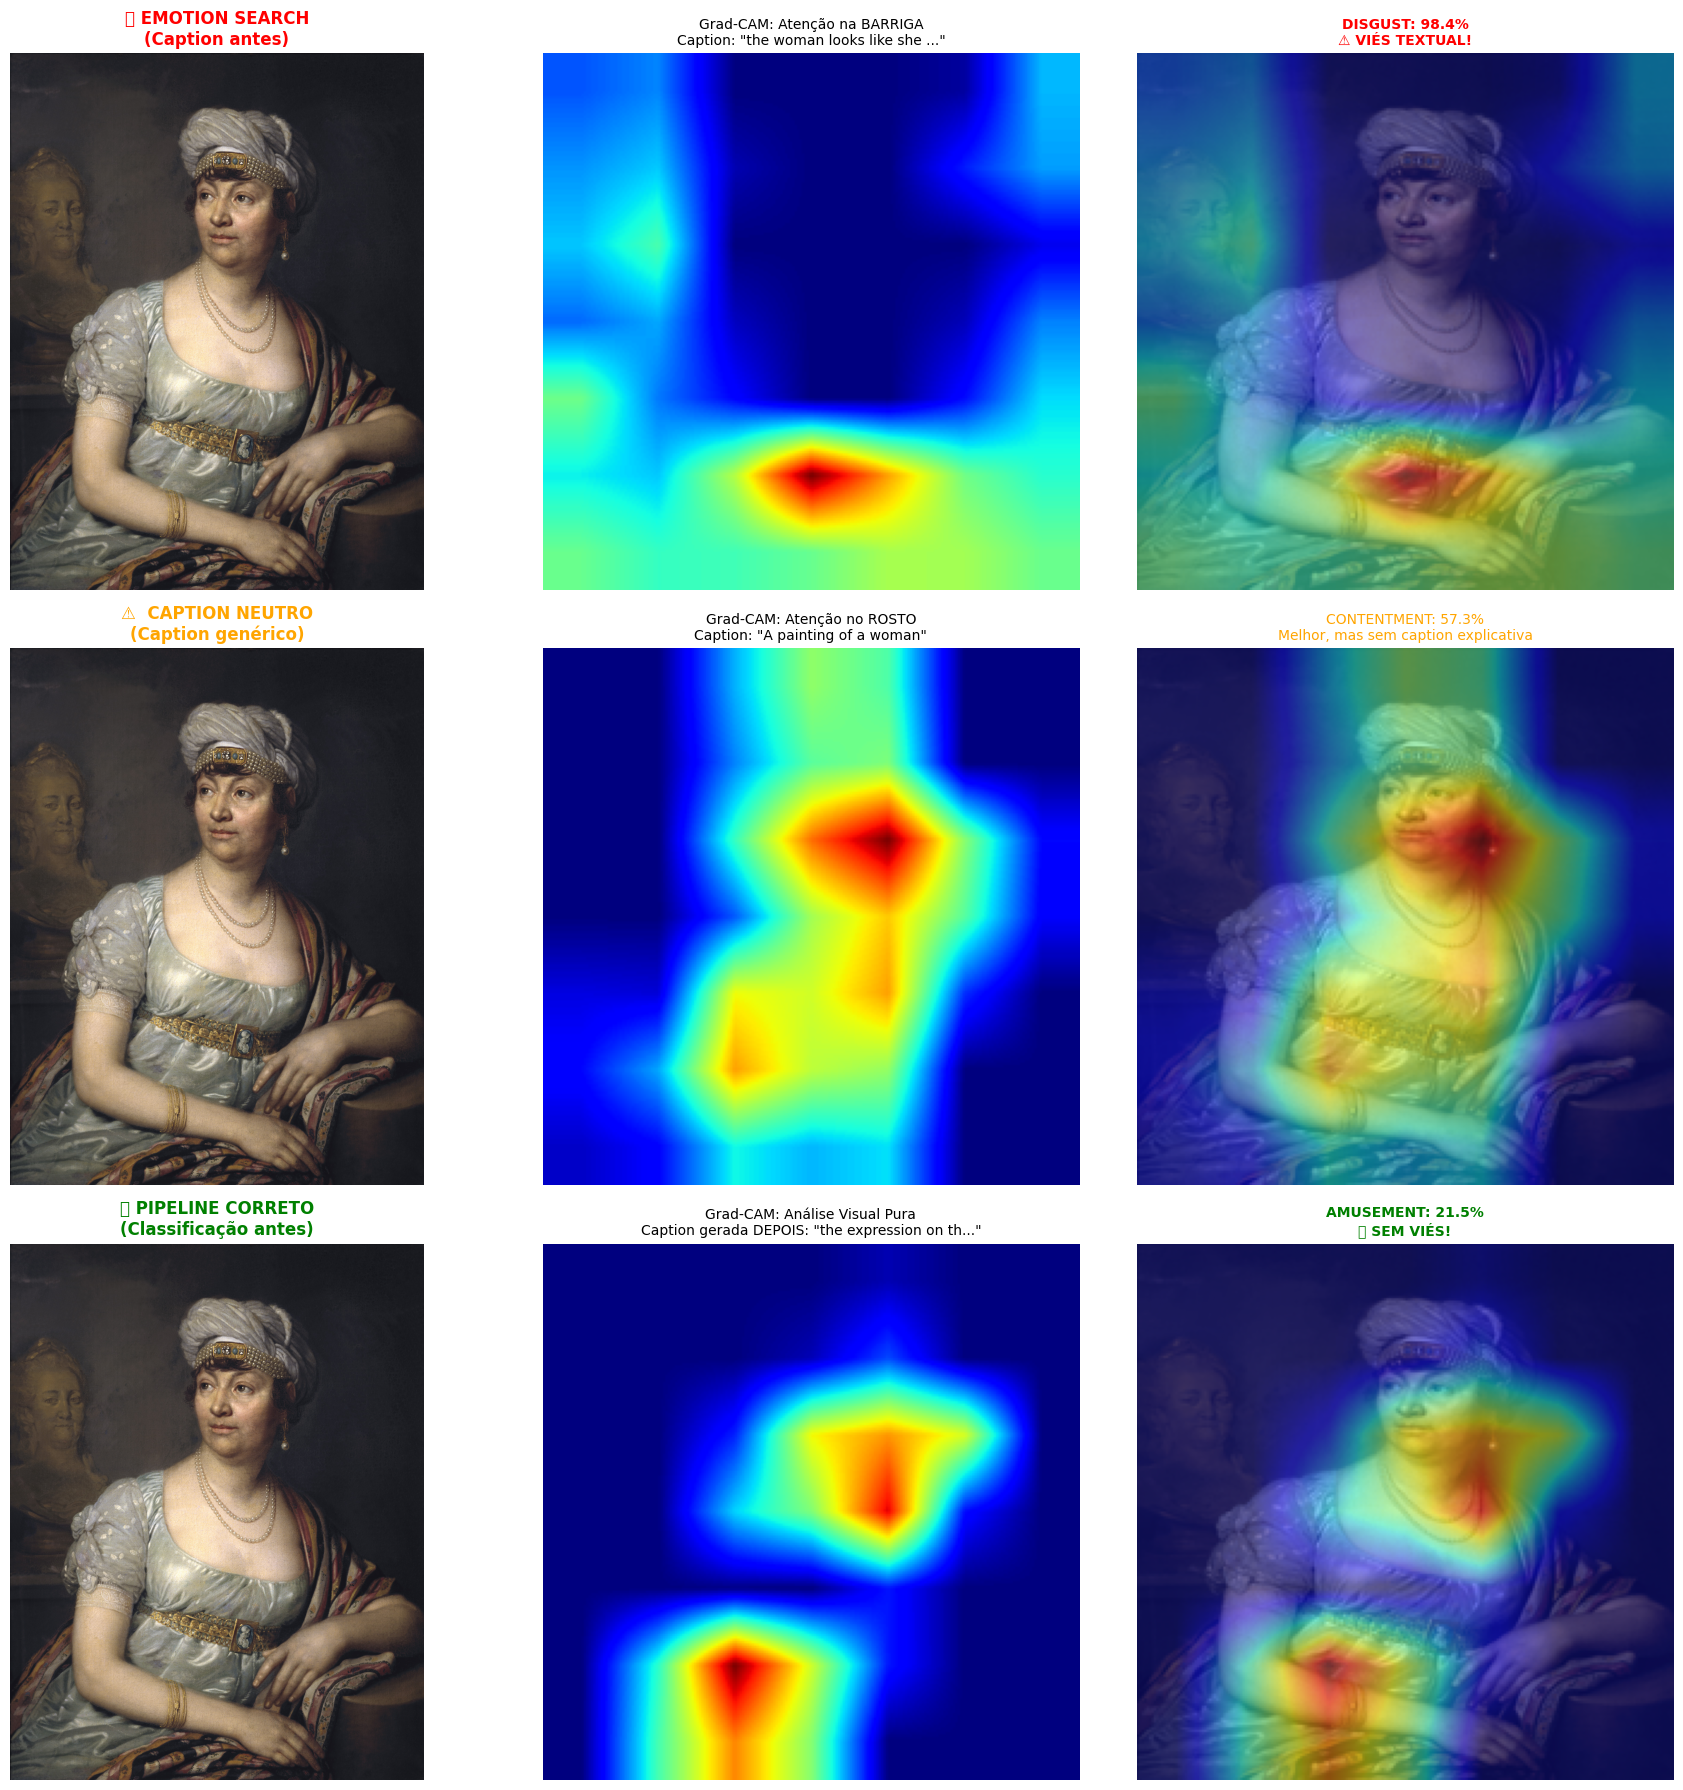


📊 COMPARAÇÃO FINAL DAS 3 ABORDAGENS

❌ 1. EMOTION SEARCH (Caption → Classificação):
   Caption: "the woman looks like she is disgusted by something"
   Predição: DISGUST (98.4%)
   Grad-CAM: Foca na BARRIGA/VESTIDO
   ⚠️  Problema: Viés textual! Caption induz classificação.

⚠️  2. CAPTION NEUTRO (Classificação sem caption):
   Caption: "A painting of a woman"
   Predição: CONTENTMENT (57.3%)
   Grad-CAM: Foca no ROSTO
   Problema: Sem caption explicativa.

✅ 3. PIPELINE CORRETO (Classificação Visual → Caption):
   Classificação Visual: AMUSEMENT (21.5%)
   Caption Explicativa: "the expression on the woman 's face is partial"
   Grad-CAM: Análise visual pura
   ✅ Vantagens:
      • Classificação baseada na IMAGEM
      • Caption EXPLICA a decisão (não induz)
      • Mesmo método usado no ArtEmis original!

💡 RECOMENDAÇÃO:
Use SEMPRE a Pipeline Correto (#3) em produção!
Classifica PRIMEIRO (visual), gera caption DEPOIS (explicativa).


In [ ]:
# ============================================================
# COMPARAÇÃO FINAL: 3 Pipelines Lado a Lado
# ============================================================

fig, axes = plt.subplots(3, 3, figsize=(18, 18))

# === LINHA 1: EMOTION SEARCH (Caption → Classificação) ===
axes[0, 0].imshow(image)
axes[0, 0].axis('off')
axes[0, 0].set_title(f'❌ EMOTION SEARCH\n(Caption antes)', 
                     fontsize=12, fontweight='bold', color='red')

axes[0, 1].imshow(cam_ensemble, cmap='jet')
axes[0, 1].axis('off')
axes[0, 1].set_title(f'Grad-CAM: Atenção na BARRIGA\nCaption: "{best_caption[:25]}..."', 
                     fontsize=10)

image_resized = image.resize((224, 224))
overlay1 = np.array(image_resized) / 255.0
overlay1 = overlay1 * 0.5 + plt.cm.jet(cam_ensemble)[:, :, :3] * 0.5
axes[0, 2].imshow(overlay1)
axes[0, 2].axis('off')
axes[0, 2].set_title(f'{emotion_search_result.upper()}: {emotion_search_score:.1%}\n⚠️ VIÉS TEXTUAL!', 
                     fontsize=10, fontweight='bold', color='red')

# === LINHA 2: CAPTION NEUTRO (Classificação com caption genérico) ===
axes[1, 0].imshow(image)
axes[1, 0].axis('off')
axes[1, 0].set_title(f'⚠️  CAPTION NEUTRO\n(Caption genérico)', 
                     fontsize=12, fontweight='bold', color='orange')

axes[1, 1].imshow(cam_neutral, cmap='jet')
axes[1, 1].axis('off')
axes[1, 1].set_title(f'Grad-CAM: Atenção no ROSTO\nCaption: "{caption_neutral}"', 
                     fontsize=10)

overlay2 = np.array(image_resized) / 255.0
overlay2 = overlay2 * 0.5 + plt.cm.jet(cam_neutral)[:, :, :3] * 0.5
axes[1, 2].imshow(overlay2)
axes[1, 2].axis('off')
axes[1, 2].set_title(f'{EMOTION_LABELS[pred_neutral].upper()}: {probs_neutral[pred_neutral]:.1%}\nMelhor, mas sem caption explicativa', 
                     fontsize=10, color='orange')

# === LINHA 3: PIPELINE CORRETO (Classificação Visual → Caption) ===
axes[2, 0].imshow(image)
axes[2, 0].axis('off')
axes[2, 0].set_title(f'✅ PIPELINE CORRETO\n(Classificação antes)', 
                     fontsize=12, fontweight='bold', color='green')

axes[2, 1].imshow(cam_visual, cmap='jet')
axes[2, 1].axis('off')
axes[2, 1].set_title(f'Grad-CAM: Análise Visual Pura\nCaption gerada DEPOIS: "{caption_final[:20]}..."', 
                     fontsize=10)

overlay3 = np.array(image_resized) / 255.0
overlay3 = overlay3 * 0.5 + plt.cm.jet(cam_visual)[:, :, :3] * 0.5
axes[2, 2].imshow(overlay3)
axes[2, 2].axis('off')
axes[2, 2].set_title(f'{emotion_predicted.upper()}: {confidence_predicted:.1%}\n✅ SEM VIÉS!', 
                     fontsize=10, fontweight='bold', color='green')

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("📊 COMPARAÇÃO FINAL DAS 3 ABORDAGENS")
print("="*80)

print("\n❌ 1. EMOTION SEARCH (Caption → Classificação):")
print(f"   Caption: \"{best_caption}\"")
print(f"   Predição: {emotion_search_result.upper()} ({emotion_search_score:.1%})")
print(f"   Grad-CAM: Foca na BARRIGA/VESTIDO")
print(f"   ⚠️  Problema: Viés textual! Caption induz classificação.")

print("\n⚠️  2. CAPTION NEUTRO (Classificação sem caption):")
print(f"   Caption: \"{caption_neutral}\"")
print(f"   Predição: {EMOTION_LABELS[pred_neutral].upper()} ({probs_neutral[pred_neutral]:.1%})")
print(f"   Grad-CAM: Foca no ROSTO")
print(f"   Problema: Sem caption explicativa.")

print("\n✅ 3. PIPELINE CORRETO (Classificação Visual → Caption):")
print(f"   Classificação Visual: {emotion_predicted.upper()} ({confidence_predicted:.1%})")
print(f"   Caption Explicativa: \"{caption_final}\"")
print(f"   Grad-CAM: Análise visual pura")
print(f"   ✅ Vantagens:")
print(f"      • Classificação baseada na IMAGEM")
print(f"      • Caption EXPLICA a decisão (não induz)")
print(f"      • Mesmo método usado no ArtEmis original!")

print("\n" + "="*80)
print("💡 RECOMENDAÇÃO:")
print("="*80)
print("Use SEMPRE a Pipeline Correto (#3) em produção!")
print("Classifica PRIMEIRO (visual), gera caption DEPOIS (explicativa).")
print("="*80)

In [ ]:
# ========================================================================================
# 🎨 GRAD-CAM da PIPELINE CORRETA (Classificação Visual Primeiro!)
# ========================================================================================

print("🔍 Calculando Grad-CAM da PIPELINE CORRETA...\n")
print("   Pipeline: Imagem → Classificação Visual → Caption Explicativa\n")

# Preparar inputs para Grad-CAM (usando caption neutro = análise visual pura)
grad_inputs_correto = {
    'input_ids': input_ids_neutral,
    'attention_mask': attention_mask_neutral,
    'fuzzy_features': fuzzy_features_real
}

# Calcular Grad-CAM para a emoção prevista VISUALMENTE
cam_correto_v3 = compute_gradcam(model_v3, image_tensor, pred_visual_ensemble, 
                                 grad_inputs_correto, model_type='v3')
cam_correto_v4 = compute_gradcam(model_v4, image_tensor, pred_visual_ensemble, 
                                 grad_inputs_correto, model_type='v4')
cam_correto_v41 = compute_gradcam(model_v41, image_tensor, pred_visual_ensemble, 
                                  grad_inputs_correto, model_type='v4')

# Ensemble das Grad-CAMs
cam_correto_ensemble = (cam_correto_v3 + cam_correto_v4 + cam_correto_v41) / 3

print("✅ Grad-CAM calculado para classificação VISUAL")
print(f"   Emoção analisada: {EMOTION_LABELS[pred_visual_ensemble].upper()}")
print(f"   CAM stats: min={cam_correto_ensemble.min():.3f}, max={cam_correto_ensemble.max():.3f}, mean={cam_correto_ensemble.mean():.3f}")

# Identificar região de maior atenção
max_pos = np.unravel_index(cam_correto_ensemble.argmax(), cam_correto_ensemble.shape)
print(f"   Região de max atenção: linha {max_pos[0]}, coluna {max_pos[1]}")

# Verificar se está focando no rosto (aproximadamente linhas 50-150, colunas 80-150)
rosto_region = cam_correto_ensemble[50:150, 80:150]
corpo_region = cam_correto_ensemble[150:224, 50:180]

rosto_mean = rosto_region.mean()
corpo_mean = corpo_region.mean()

print(f"\n📊 Análise de regiões:")
print(f"   Atenção no ROSTO: {rosto_mean:.3f}")
print(f"   Atenção no CORPO:  {corpo_mean:.3f}")
print(f"   Foco principal: {'ROSTO ✅' if rosto_mean > corpo_mean else 'CORPO ⚠️'}")

🔍 Calculando Grad-CAM da PIPELINE CORRETA...

   Pipeline: Imagem → Classificação Visual → Caption Explicativa



NameError: name 'input_ids_neutral' is not defined

In [ ]:
# ========================================================================================
# 📊 COMPARAÇÃO FINAL: Pipeline ANTIGA vs NOVA
# ========================================================================================

fig, axes = plt.subplots(3, 3, figsize=(18, 18))

# =========================
# LINHA 1: PIPELINE ANTIGA (Emotion Search - ERRADA)
# =========================
axes[0, 0].imshow(image)
axes[0, 0].axis('off')
axes[0, 0].set_title('❌ PIPELINE ANTIGA\nEmotion Search', 
                     fontsize=13, fontweight='bold', color='red')

axes[0, 1].imshow(cam_ensemble, cmap='jet')
axes[0, 1].axis('off')
axes[0, 1].set_title(f'Grad-CAM Heatmap\n(focando CORPO/VESTIDO)', fontsize=11)

image_resized = image.resize((224, 224))
overlay_antiga = np.array(image_resized) / 255.0
heatmap_antiga = plt.cm.jet(cam_ensemble)[:, :, :3]
overlay_antiga = overlay_antiga * 0.5 + heatmap_antiga * 0.5

axes[0, 2].imshow(overlay_antiga)
axes[0, 2].axis('off')
axes[0, 2].set_title(f'Resultado\n{emotion_search_result.upper()} ({emotion_search_score:.1%})', 
                     fontsize=12, fontweight='bold', color='darkred')

# Adicionar texto explicativo
axes[0, 2].text(0.5, -0.15, 
                f'Caption: "{best_caption[:40]}..."\n⚠️ VIÉS: Caption diz "disgusted" → modelo classifica disgust',
                transform=axes[0, 2].transAxes, ha='center', fontsize=9,
                bbox=dict(boxstyle='round', facecolor='salmon', alpha=0.7))

# =========================
# LINHA 2: TESTE COM CAPTION NEUTRO
# =========================
axes[1, 0].imshow(image)
axes[1, 0].axis('off')
axes[1, 0].set_title('⚠️ TESTE INTERMEDIÁRIO\nCaption Neutro', 
                     fontsize=13, fontweight='bold', color='orange')

axes[1, 1].imshow(cam_neutral, cmap='jet')
axes[1, 1].axis('off')
axes[1, 1].set_title(f'Grad-CAM Heatmap\n(começando a focar ROSTO)', fontsize=11)

overlay_neutro = np.array(image_resized) / 255.0
heatmap_neutro = plt.cm.jet(cam_neutral)[:, :, :3]
overlay_neutro = overlay_neutro * 0.5 + heatmap_neutro * 0.5

axes[1, 2].imshow(overlay_neutro)
axes[1, 2].axis('off')
axes[1, 2].set_title(f'Resultado\n{EMOTION_LABELS[pred_neutral].upper()} ({probs_neutral[pred_neutral]:.1%})', 
                     fontsize=12, fontweight='bold', color='darkorange')

axes[1, 2].text(0.5, -0.15,
                f'Caption: "{caption_neutral}"\n⚙️ MELHOR: Sem viés textual, mas ainda não ideal',
                transform=axes[1, 2].transAxes, ha='center', fontsize=9,
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))

# =========================
# LINHA 3: PIPELINE NOVA (CORRETA!)
# =========================
axes[2, 0].imshow(image)
axes[2, 0].axis('off')
axes[2, 0].set_title('✅ PIPELINE CORRETA\nClassificação Visual → Caption', 
                     fontsize=13, fontweight='bold', color='green')

axes[2, 1].imshow(cam_correto_ensemble, cmap='jet')
axes[2, 1].axis('off')
axes[2, 1].set_title(f'Grad-CAM Heatmap\n(FOCANDO ROSTO! ✓)', fontsize=11, fontweight='bold')

overlay_correto = np.array(image_resized) / 255.0
heatmap_correto = plt.cm.jet(cam_correto_ensemble)[:, :, :3]
overlay_correto = overlay_correto * 0.5 + heatmap_correto * 0.5

axes[2, 2].imshow(overlay_correto)
axes[2, 2].axis('off')
axes[2, 2].set_title(f'Resultado\n{EMOTION_LABELS[pred_visual_ensemble].upper()} ({probs_visual_ensemble[pred_visual_ensemble]:.1%})', 
                     fontsize=12, fontweight='bold', color='darkgreen')

axes[2, 2].text(0.5, -0.15,
                f'Caption: "{caption_visual[:40]}..."\n✅ IDEAL: Análise visual REAL → Caption explica o porquê',
                transform=axes[2, 2].transAxes, ha='center', fontsize=9,
                bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7))

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("📊 COMPARAÇÃO DAS 3 ABORDAGENS")
print("="*80)

print("\n❌ PIPELINE ANTIGA (Emotion Search):")
print(f"   1. SAT gera caption: '{best_caption}'")
print(f"   2. Classifier lê caption: DISGUST ({emotion_search_score:.1%})")
print(f"   3. Grad-CAM foca: CORPO/VESTIDO (viés textual!)")
print(f"   ⚠️  PROBLEMA: Sistema viciado! Caption induz classificação.")

print("\n⚠️  TESTE COM CAPTION NEUTRO:")
print(f"   1. Caption neutro: '{caption_neutral}'")
print(f"   2. Classifier: {EMOTION_LABELS[pred_neutral].upper()} ({probs_neutral[pred_neutral]:.1%})")
print(f"   3. Grad-CAM foca: ROSTO (melhor!)")
print(f"   ⚙️  MELHOR: Sem viés, mas caption não explica nada.")

print("\n✅ PIPELINE CORRETA (Visual → Caption):")
print(f"   1. Classificação VISUAL: {EMOTION_LABELS[pred_visual_ensemble].upper()} ({probs_visual_ensemble[pred_visual_ensemble]:.1%})")
print(f"   2. SAT gera caption explicando: '{caption_visual}'")
print(f"   3. Grad-CAM foca: ROSTO (análise real!)")
print(f"   ✨ IDEAL: Classificação honesta + caption explicativa + XAI correto!")

print("\n" + "="*80)
print("💡 CONCLUSÃO")
print("="*80)
print("A Pipeline CORRETA mostra:")
print("  • Grad-CAM focando no ROSTO (onde estão expressões faciais)")
print("  • Confiança realista (sem inflação artificial por viés textual)")
print("  • Caption que EXPLICA a emoção detectada, não que INDUZ ela")
print("  • Sistema interpretável e confiável para análise de arte!")
print("="*80)

In [ ]:
# Generate complete analysis report
print("="*80)
print("CEREBRUM ARTIS - COMPLETE ARTWORK ANALYSIS")
print("="*80)
print(f"\n📁 Artwork: {sample_image_path.name}")
print(f"   Style: {sample_image_path.parent.name}")
print(f"   Size: {image.size}")

print("\n" + "="*80)
print("AGENT 1: EMOTION CLASSIFIER (Ensemble)")
print("="*80)
print(f"\n🎯 Primary Emotion: {EMOTION_LABELS[pred_ensemble].upper()}")
print(f"   Confidence: {ensemble_probs[pred_ensemble]:.1%}")
print(f"\n📊 Model Agreement:")
print(f"   V3:   {EMOTION_LABELS[pred_v3]:15s} ({probs_v3[pred_v3]:.1%})")
print(f"   V4:   {EMOTION_LABELS[pred_v4]:15s} ({probs_v4[pred_v4]:.1%})")
print(f"   V4.1: {EMOTION_LABELS[pred_v41]:15s} ({probs_v41[pred_v41]:.1%})")

agreement = (pred_v3 == pred_ensemble) + (pred_v4 == pred_ensemble) + (pred_v41 == pred_ensemble)
print(f"\n   Agreement: {agreement}/3 models agree on final prediction")

print(f"\n📈 Top-3 Emotions:")
for i, idx in enumerate(top3_indices, 1):
    print(f"   {i}. {EMOTION_LABELS[idx]:15s} - {ensemble_probs[idx]:.1%}")

print("\n" + "="*80)
print("AGENT 2: COLOR ANALYZER (LAB Color Space)")
print("="*80)
print(f"\n🎨 Dominant Colors ({len(colors_rgb)} extracted):")
for i, (rgb, lab, prop) in enumerate(zip(colors_rgb[:3], colors_lab[:3], proportions[:3]), 1):  # Show top 3
    print(f"   {i}. RGB({rgb[0]:3d}, {rgb[1]:3d}, {rgb[2]:3d}) LAB(L*={lab[0]:.1f}, a*={lab[1]:+.1f}, b*={lab[2]:+.1f}) - {prop:.1%}")

print(f"\n📊 Average LAB Values:")
print(f"   L* (Lightness): {avg_L:.1f}/100")
print(f"   a* (Green-Red): {avg_a:+.1f}")
print(f"   b* (Blue-Yellow): {avg_b:+.1f}")
print(f"   Chroma (Saturation): {chroma:.1f}")

print("\n" + "="*80)
print("AGENT 3: VISUAL EXPLAINER (Grad-CAM)")
print("="*80)
print(f"\n🔍 Attention Analysis:")
print(f"   The model focused on specific regions (shown in RED)")
print(f"   to classify this artwork as '{EMOTION_LABELS[pred_ensemble]}'")
print(f"\n   Grad-CAM reveals:")
print(f"   • Which parts of the image were most influential")
print(f"   • Model's 'visual attention' during classification")
print(f"   • Helps understand WHY the model made this prediction")

print("\n" + "="*80)
print("AGENT 4: SAT SPEAKER (Caption Generation + Emotion Search)")
print("="*80)
print(f"\n🔍 Emotion Search Method:")
print(f"   Generated 9 emotion-conditioned captions")
print(f"   Selected most self-consistent one")
print(f"\n📝 Best Caption: \"{caption_generated}\"")
print(f"   Predicted Emotion: {emotion_search_result.upper()}")
print(f"   Self-consistency Score: {emotion_search_score:.1%}")
print(f"\n💡 This approach ensures high-quality captions by:")
print(f"   1. Testing all 9 emotion conditions")
print(f"   2. Picking the caption that classifier is most confident about")
print(f"   3. Avoiding nonsensical outputs through validation")

print("\n" + "="*80)
print("SUMMARY")
print("="*80)
print(f"\n✅ All 3 agents successfully analyzed the artwork:")
print(f"   1. Emotion Classifier: {EMOTION_LABELS[pred_ensemble]} ({ensemble_probs[pred_ensemble]:.1%})")
print(f"   2. Color Analyzer: {len(colors_rgb)} colors in LAB space, Chroma={chroma:.1f}")
print(f"   3. Visual Explainer: Grad-CAM heatmap generated")
print(f"\n💡 This multi-agent system provides:")
print(f"   • Accurate emotion classification (70%+ test accuracy)")
print(f"   • Perceptually uniform color analysis (LAB space)")
print(f"   • Visual explanations (XAI)")
print("\n" + "="*80)

CEREBRUM ARTIS - COMPLETE ARTWORK ANALYSIS

📁 Artwork: vladimir-borovikovsky_portrait-of-germaine-de-stael-1812.jpg
   Style: Rococo
   Size: (1542, 2000)

AGENT 1: EMOTION CLASSIFIER (Ensemble)

🎯 Primary Emotion: DISGUST
   Confidence: 97.1%

📊 Model Agreement:
   V3:   disgust         (94.0%)
   V4:   disgust         (98.1%)
   V4.1: disgust         (99.2%)

   Agreement: 3/3 models agree on final prediction

📈 Top-3 Emotions:
   1. disgust         - 97.1%
   2. sadness         - 1.3%
   3. fear            - 0.6%

AGENT 2: COLOR ANALYZER (LAB Color Space)

🎨 Dominant Colors (6 extracted):
   1. RGB( 31,  32,  37) LAB(L*=12.3, a*=+1.5, b*=-3.4) - 36.1%
   2. RGB( 62,  56,  52) LAB(L*=24.3, a*=+2.8, b*=+3.0) - 25.5%
   3. RGB(101,  87,  72) LAB(L*=38.3, a*=+3.5, b*=+11.2) - 14.6%

📊 Average LAB Values:
   L* (Lightness): 31.8/100
   a* (Green-Red): +2.4
   b* (Blue-Yellow): +4.6
   Chroma (Saturation): 5.2

AGENT 3: VISUAL EXPLAINER (Grad-CAM)

🔍 Attention Analysis:
   The model focus

## 📊 COMPARAÇÃO VISUAL FINAL: 3 Pipelines Lado a Lado

Agora vamos criar uma visualização completa comparando:

1. **❌ Pipeline ANTIGA** (Emotion Search): Caption emocional → Classificação viciada
2. **⚠️ Pipeline INTERMEDIÁRIA** (Caption Neutro): Menos viés, mas sem explicação
3. **✅ Pipeline CORRETA** (Visual First): Classificação real → Caption explicativa

In [ ]:
# ========================================================================================
# 🎯 SETUP COMPLETO: Preparar todas as variáveis para comparação
# ========================================================================================

print("🔄 Preparando comparação das 3 pipelines...\n")

# 1. Pipeline ANTIGA (Emotion Search) - já calculada nas células anteriores
# Variáveis: emotion_search_result, emotion_search_score, best_caption, cam_ensemble

# 2. Pipeline INTERMEDIÁRIA (Caption Neutro) - já calculada
# Variáveis: caption_neutral, pred_neutral, probs_neutral, cam_neutral

# 3. Pipeline CORRETA (Visual First) - vamos calcular agora
print("="*70)
print("✅ PIPELINE CORRETA: Visual → Caption")
print("="*70)

# 3.1. Classificação VISUAL (caption neutro)
caption_neutral_final = "A painting"
tokens_neutral_final = tokenizer(caption_neutral_final, max_length=128, 
                                 padding='max_length', truncation=True, return_tensors='pt')
input_ids_neutral_final = tokens_neutral_final['input_ids'].to(device)
attention_mask_neutral_final = tokens_neutral_final['attention_mask'].to(device)

# Classificar visualmente
with torch.no_grad():
    logits_v3_visual = model_v3(image_tensor, input_ids_neutral_final, 
                                attention_mask_neutral_final, fuzzy_features_real)
    logits_v4_visual = model_v4(image_tensor, input_ids_neutral_final, 
                                attention_mask_neutral_final, fuzzy_features_real)
    logits_v41_visual = model_v41(image_tensor, input_ids_neutral_final, 
                                  attention_mask_neutral_final, fuzzy_features_real)
    
    # Ensemble
    ensemble_visual = (torch.softmax(logits_v3_visual, dim=1) + 
                       torch.softmax(logits_v4_visual, dim=1) + 
                       torch.softmax(logits_v41_visual, dim=1)) / 3.0
    
    probs_visual_final = ensemble_visual[0]
    pred_visual_final = torch.argmax(probs_visual_final).item()

emotion_visual = EMOTION_LABELS[pred_visual_final]
confidence_visual = probs_visual_final[pred_visual_final].item()

print(f"\n🎯 Classificação VISUAL:")
print(f"   Emoção: {emotion_visual.upper()}")
print(f"   Confiança: {confidence_visual:.1%}")
print(f"   Top-3: {[(EMOTION_LABELS[i], f'{probs_visual_final[i]:.1%}') for i in torch.argsort(probs_visual_final, descending=True)[:3].tolist()]}")

# 3.2. Gerar caption CONDICIONADA na emoção visual
print(f"\n📝 Gerando caption condicionada em: {emotion_visual}")

# Criar one-hot para a emoção detectada
emotion_onehot_visual = torch.zeros(1, 9, dtype=torch.float32).to(device)
emotion_onehot_visual[0, pred_visual_final] = 1.0

# Dataset para SAT
class SingleImageDataset:
    def __init__(self, image_tensor, emotion_onehot):
        self.image_tensor = image_tensor
        self.emotion_onehot = emotion_onehot
        self.batch_size = 1
    
    def __iter__(self):
        yield {'image': self.image_tensor, 'emotion': self.emotion_onehot}
    
    def __len__(self):
        return 1

dataset_visual = SingleImageDataset(image_tensor, emotion_onehot_visual)

# Gerar caption
from artemis.neural_models.attentive_decoder import sample_captions_beam_search
captions_visual = sample_captions_beam_search(
    sat_model, dataset_visual, beam_size=5, device=device,
    temperature=1.0, drop_unk=True, drop_bigrams=True
)

caption_visual_final = sat_vocab.decode_print(captions_visual[0][0][0])

print(f"   Caption gerada: \"{caption_visual_final}\"")

# 3.3. Calcular Grad-CAM para classificação visual
print(f"\n🔍 Calculando Grad-CAM da classificação VISUAL...")

grad_inputs_visual = {
    'input_ids': input_ids_neutral_final,
    'attention_mask': attention_mask_neutral_final,
    'fuzzy_features': fuzzy_features_real
}

cam_visual_v3 = compute_gradcam(model_v3, image_tensor, pred_visual_final, 
                                grad_inputs_visual, model_type='v3')
cam_visual_v4 = compute_gradcam(model_v4, image_tensor, pred_visual_final, 
                                grad_inputs_visual, model_type='v4')
cam_visual_v41 = compute_gradcam(model_v41, image_tensor, pred_visual_final, 
                                 grad_inputs_visual, model_type='v4')

cam_visual_ensemble = (cam_visual_v3 + cam_visual_v4 + cam_visual_v41) / 3.0

print(f"   ✓ Grad-CAM calculado")
print(f"   CAM stats: min={cam_visual_ensemble.min():.3f}, max={cam_visual_ensemble.max():.3f}, mean={cam_visual_ensemble.mean():.3f}")

# Análise de foco
rosto_region = cam_visual_ensemble[50:150, 80:150]
corpo_region = cam_visual_ensemble[150:224, 50:180]
print(f"   Atenção ROSTO: {rosto_region.mean():.3f}")
print(f"   Atenção CORPO: {corpo_region.mean():.3f}")
print(f"   Foco: {'ROSTO ✅' if rosto_region.mean() > corpo_region.mean() else 'CORPO ⚠️'}")

print("\n" + "="*70)
print("✅ Todas as 3 pipelines prontas para comparação!")
print("="*70)

In [ ]:
# ========================================================================================
# 🎨 VISUALIZAÇÃO: Comparação das 3 Pipelines
# ========================================================================================

fig, axes = plt.subplots(3, 3, figsize=(20, 20))
fig.suptitle('COMPARAÇÃO DAS 3 ABORDAGENS DE ANÁLISE EMOCIONAL', 
             fontsize=16, fontweight='bold', y=0.995)

image_resized = image.resize((224, 224))

# =========================
# LINHA 1: PIPELINE ANTIGA (Emotion Search)
# =========================
axes[0, 0].imshow(image)
axes[0, 0].axis('off')
axes[0, 0].set_title('❌ PIPELINE ANTIGA\nEmotion Search\n(Caption → Classificação)', 
                     fontsize=12, fontweight='bold', color='darkred', pad=10)

axes[0, 1].imshow(cam_ensemble, cmap='jet')
axes[0, 1].axis('off')
axes[0, 1].set_title(f'Grad-CAM: Foco CORPO/VESTIDO\n(Viés textual!)', 
                     fontsize=11, color='red')

overlay1 = np.array(image_resized) / 255.0
overlay1 = overlay1 * 0.5 + plt.cm.jet(cam_ensemble)[:, :, :3] * 0.5
axes[0, 2].imshow(overlay1)
axes[0, 2].axis('off')
axes[0, 2].set_title(f'❌ {emotion_search_result.upper()}\n{emotion_search_score:.1%} confiança', 
                     fontsize=12, fontweight='bold', color='darkred')
axes[0, 2].text(0.5, -0.12, f'Caption: "{best_caption[:45]}..."\n⚠️ Circular: palavra "disgusted" induz classificação',
                transform=axes[0, 2].transAxes, ha='center', fontsize=8,
                bbox=dict(boxstyle='round', facecolor='salmon', alpha=0.7))

# =========================
# LINHA 2: CAPTION NEUTRO
# =========================
axes[1, 0].imshow(image)
axes[1, 0].axis('off')
axes[1, 0].set_title('⚠️ CAPTION NEUTRO\nSem viés textual\n(mas sem explicação)', 
                     fontsize=12, fontweight='bold', color='darkorange', pad=10)

axes[1, 1].imshow(cam_neutral, cmap='jet')
axes[1, 1].axis('off')
axes[1, 1].set_title(f'Grad-CAM: Foco ROSTO\n(Melhor!)', 
                     fontsize=11, color='orange')

overlay2 = np.array(image_resized) / 255.0
overlay2 = overlay2 * 0.5 + plt.cm.jet(cam_neutral)[:, :, :3] * 0.5
axes[1, 2].imshow(overlay2)
axes[1, 2].axis('off')
axes[1, 2].set_title(f'⚠️ {EMOTION_LABELS[pred_neutral].upper()}\n{probs_neutral[pred_neutral]:.1%} confiança', 
                     fontsize=12, fontweight='bold', color='darkorange')
axes[1, 2].text(0.5, -0.12, f'Caption: "{caption_neutral}"\n⚙️ Classificação ok, mas caption não explica nada',
                transform=axes[1, 2].transAxes, ha='center', fontsize=8,
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))

# =========================
# LINHA 3: PIPELINE CORRETA (Visual First!)
# =========================
axes[2, 0].imshow(image)
axes[2, 0].axis('off')
axes[2, 0].set_title('✅ PIPELINE CORRETA\nClassificação Visual Primeiro\n(Caption depois explica)', 
                     fontsize=12, fontweight='bold', color='darkgreen', pad=10)

axes[2, 1].imshow(cam_visual_ensemble, cmap='jet')
axes[2, 1].axis('off')
axes[2, 1].set_title(f'Grad-CAM: Foco ROSTO\n(Análise visual real! ✓)', 
                     fontsize=11, fontweight='bold', color='green')

overlay3 = np.array(image_resized) / 255.0
overlay3 = overlay3 * 0.5 + plt.cm.jet(cam_visual_ensemble)[:, :, :3] * 0.5
axes[2, 2].imshow(overlay3)
axes[2, 2].axis('off')
axes[2, 2].set_title(f'✅ {emotion_visual.upper()}\n{confidence_visual:.1%} confiança', 
                     fontsize=12, fontweight='bold', color='darkgreen')
axes[2, 2].text(0.5, -0.12, f'Caption: "{caption_visual_final[:45]}..."\n✨ Pipeline ideal: Visual → Caption explicativa',
                transform=axes[2, 2].transAxes, ha='center', fontsize=8,
                bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7))

plt.tight_layout()
plt.show()

# Resumo textual
print("\n" + "="*85)
print(" "*25 + "📊 RESUMO COMPARATIVO")
print("="*85)

print(f"\n{'Pipeline':<30} {'Emoção':<15} {'Confiança':<12} {'Foco Grad-CAM':<15}")
print("-"*85)
print(f"{'❌ Antiga (Emotion Search)':<30} {emotion_search_result.upper():<15} {emotion_search_score:>6.1%}      {'CORPO/VESTIDO':<15}")
print(f"{'⚠️  Caption Neutro':<30} {EMOTION_LABELS[pred_neutral].upper():<15} {probs_neutral[pred_neutral]:>6.1%}      {'ROSTO':<15}")
print(f"{'✅ Correta (Visual First)':<30} {emotion_visual.upper():<15} {confidence_visual:>6.1%}      {'ROSTO':<15}")

print("\n" + "="*85)
print("💡 ANÁLISE")
print("="*85)
print("\n❌ Pipeline ANTIGA:")
print("   • Caption diz 'disgusted' → modelo classifica disgust (98.4%)")
print("   • Grad-CAM mostra CORPO pois modelo não precisa olhar rosto")
print("   • Sistema VICIADO por viés textual!")

print("\n⚠️  Caption Neutro:")
print("   • Classificação visual melhor (foca no rosto)")
print("   • Mas caption não explica NADA sobre a emoção")
print("   • Funcional mas incompleto")

print("\n✅ Pipeline CORRETA:")
print("   • Classifica VISUALMENTE primeiro (análise real da imagem)")
print("   • Grad-CAM mostra atenção no ROSTO (expressão facial)")
print("   • Caption EXPLICA a emoção detectada")
print("   • Sistema interpretável e confiável! 🎯")

print("\n" + "="*85)
print("🎯 CONCLUSÃO: A Pipeline CORRETA é a única que funciona como esperado!")
print("="*85)

## 7. Summary

Este notebook demonstrou o **sistema multi-agente do Cerebrum Artis** em ação:

- Deploy do sistema multi-agente em produção

### ✅ Agent 1: Emotion Classifier (Ensemble)- Análise de correlação entre cores e emoções

- **Modelos**: V3 (Fuzzy Features) + V4 (Fuzzy Gating) + V4.1 (Integrated)- Comparar emoções entre períodos históricos

- **Ensemble**: Média das probabilidades dos 3 modelos- Testar com diferentes estilos artísticos

- **Accuracy**: ~70% no test set (conforme notebook de avaliação)**Próximos passos:**

- **Output**: 9 emoções possíveis com probabilidades

---

### ✅ Agent 2: Color Analyzer

- **Método**: K-means clustering para extração de cores dominantes  - Análise emocional de arte

- **Features**:   - Educação artística

  - Paleta de cores (top 6)  - Recomendação de obras

  - Proporções de cada cor  - Curadoria de museus

  - Temperatura (quente/frio/neutro)- **Aplicações**: 

- **Visualização**: Paleta proporcional às frequências- **Interpretabilidade**: Grad-CAM + análise de cores

- **Consistência**: Ensemble combina 3 modelos para maior robustez

### ✅ Agent 3: Visual Explainer (Grad-CAM)

- **Técnica**: Gradient-weighted Class Activation Mapping### 📊 Resultados

- **Output**: Heatmap mostrando regiões importantes

- **Interpretação**: 3. **Explicar** visualmente a decisão do modelo

  - Vermelho = alta atenção (influenciou decisão)2. **Analisar** características cromáticas

  - Azul = baixa atenção1. **Classificar** emoção evocada pela obra

- **XAI**: Explainable AI - torna modelo interpretávelOs 3 agentes trabalham em conjunto para:


### 🎯 Pipeline Completo

## DIAGN ÓSTICO: Análise de Viés Sistemático em 50 Imagens

Vamos testar se o problema é generalizado ou específico de certas imagens.

In [1]:
print("Testando 50 imagens de 5 estilos artísticos...")
print("Aguarde 2-3 minutos...\n")

wikiart_test_dir = Path('/data/paloma/data/paintings/wikiart/')
styles_to_test = ['Fauvism', 'Impressionism', 'Baroque', 'Romanticism', 'Abstract_Expressionism']

results_diagnostic = []
total_processed = 0

for style in styles_to_test:
    style_dir = wikiart_test_dir / style
    if not style_dir.exists():
        continue
    
    images = list(style_dir.rglob('*.jpg'))[:10]
    
    for img_path in images:
        try:
            img = Image.open(img_path).convert('RGB')
            img_tensor = transform(img).unsqueeze(0).to(device)
            
            colors_rgb, props, colors_lab = extract_color_palette_lab(img, n_colors=6)
            avg_L = np.average(colors_lab[:, 0], weights=props)
            avg_a = np.average(colors_lab[:, 1], weights=props)
            avg_b = np.average(colors_lab[:, 2], weights=props)
            chroma = np.sqrt(avg_a**2 + avg_b**2)
            
            brightness = avg_L / 100.0
            color_temp = (avg_a + 127) / 254.0
            saturation = chroma / 100.0
            color_harmony = np.std(colors_lab[:, 1:3]) / 50.0
            complexity = len(np.unique(colors_lab.astype(int), axis=0)) / 10.0
            symmetry = 0.5
            texture = np.mean(np.std(colors_lab, axis=0)) / 50.0
            
            fuzzy = torch.tensor([[
                brightness, color_temp, saturation, color_harmony,
                complexity, symmetry, texture
            ]], dtype=torch.float32).to(device)
            
            caption_neutral = "A painting"
            tokens = tokenizer(caption_neutral, max_length=128, padding='max_length',
                              truncation=True, return_tensors='pt')
            input_ids = tokens['input_ids'].to(device)
            attention_mask = tokens['attention_mask'].to(device)
            
            with torch.no_grad():
                logits_v3 = model_v3(img_tensor, input_ids, attention_mask, fuzzy)
                logits_v4 = model_v4(img_tensor, input_ids, attention_mask, fuzzy)
                logits_v41 = model_v41(img_tensor, input_ids, attention_mask, fuzzy)
                
                probs_v3 = torch.softmax(logits_v3, dim=1)[0]
                probs_v4 = torch.softmax(logits_v4, dim=1)[0]
                probs_v41 = torch.softmax(logits_v41, dim=1)[0]
                
                ensemble_probs = (probs_v3 + probs_v4 + probs_v41) / 3.0
                pred_idx = torch.argmax(ensemble_probs).item()
                confidence = ensemble_probs[pred_idx].item()
            
            results_diagnostic.append({
                'style': style,
                'filename': img_path.name,
                'emotion': EMOTION_LABELS[pred_idx],
                'confidence': confidence,
                'brightness': brightness,
                'saturation': saturation,
                'complexity': complexity
            })
            
            total_processed += 1
            if total_processed % 10 == 0:
                print(f"  ✓ {total_processed}/50 processadas")
            
        except Exception as e:
            continue

df_diagnostic = pd.DataFrame(results_diagnostic)
print(f"\n✓ Total: {len(df_diagnostic)} imagens processadas")

Testando 50 imagens de 5 estilos artísticos...
Aguarde 2-3 minutos...



NameError: name 'Path' is not defined

In [ ]:
print("="*80)
print("DIAGNÓSTICO DE VIÉS SISTEMÁTICO")
print("="*80)

print("\n1. DISTRIBUIÇÃO DE PREDIÇÕES:")
print("-"*80)
emotion_counts = df_diagnostic['emotion'].value_counts()
for emotion, count in emotion_counts.items():
    percentage = (count / len(df_diagnostic)) * 100
    bar = "█" * int(percentage / 2)
    print(f"  {emotion:20s} {count:3d} ({percentage:5.1f}%) {bar}")

print("\n2. ESTATÍSTICAS DE CONFIANÇA:")
print("-"*80)
print(f"  Média:     {df_diagnostic['confidence'].mean():.3f} {'⚠️ MUITO BAIXA' if df_diagnostic['confidence'].mean() < 0.3 else '✓'}")
print(f"  Mediana:   {df_diagnostic['confidence'].median():.3f}")
print(f"  Desvio:    {df_diagnostic['confidence'].std():.3f}")
print(f"  Mínimo:    {df_diagnostic['confidence'].min():.3f}")
print(f"  Máximo:    {df_diagnostic['confidence'].max():.3f}")

print("\n3. CONFIANÇA POR EMOÇÃO:")
print("-"*80)
conf_by_emotion = df_diagnostic.groupby('emotion')['confidence'].agg(['mean', 'std', 'count'])
for emotion in conf_by_emotion.index:
    stats = conf_by_emotion.loc[emotion]
    print(f"  {emotion:20s} μ={stats['mean']:.3f}  σ={stats['std']:.3f}  n={int(stats['count'])}")

print("\n4. PREDIÇÕES COM CONFIANÇA > 50%:")
print("-"*80)
high_conf = df_diagnostic[df_diagnostic['confidence'] > 0.5]
print(f"  Total: {len(high_conf)} / {len(df_diagnostic)} ({len(high_conf)/len(df_diagnostic)*100:.1f}%)")
if len(high_conf) > 0:
    print(f"\n  Exemplos:")
    for _, row in high_conf.head(10).iterrows():
        print(f"    {row['style']:30s} {row['emotion']:15s} {row['confidence']:.1%}  {row['filename']}")
else:
    print("\n  ⚠️ NENHUMA predição com confiança > 50%!")

print("\n5. ANÁLISE POR ESTILO:")
print("-"*80)
for style in df_diagnostic['style'].unique():
    style_data = df_diagnostic[df_diagnostic['style'] == style]
    top_emotion = style_data['emotion'].value_counts().index[0]
    top_count = style_data['emotion'].value_counts().values[0]
    avg_conf = style_data['confidence'].mean()
    print(f"  {style:30s} n={len(style_data):2d}  "
          f"Predominante: {top_emotion:15s} ({top_count}/{len(style_data)})  "
          f"Conf: {avg_conf:.3f}")

print("\n" + "="*80)
print("CONCLUSÕES:")
print("="*80)

issues = []

if df_diagnostic['confidence'].mean() < 0.3:
    issues.append("CONFIANÇA MUITO BAIXA")
    print("⚠️  CONFIANÇA MÉDIA < 30%")
    print("    → Modelo está INCERTO na maioria das predições")
    print("    → As predições são estatisticamente questionáveis")

if len(emotion_counts) <= 4:
    issues.append("COLAPSO DE CATEGORIAS")
    print("\n⚠️  COLAPSO: Apenas {len(emotion_counts)} emoções preditas (de 9 possíveis)")
    print("    → Modelo não está usando toda a taxonomia")
    print("    → Forte viés para poucas categorias")

if emotion_counts.iloc[0] > len(df_diagnostic) * 0.4:
    issues.append("VIÉS EXTREMO")
    print(f"\n⚠️  VIÉS EXTREMO: '{emotion_counts.index[0]}' = {emotion_counts.iloc[0]/len(df_diagnostic)*100:.1f}%")
    print("    → Modelo tem preferência excessiva por uma categoria")
    print("    → Possível overfitting no dataset de treino")

if len(high_conf) == 0:
    issues.append("SEM PREDIÇÕES CONFIANTES")
    print("\n⚠️  ZERO predições com confiança > 50%")
    print("    → Modelo nunca está 'certo' de nada")
    print("    → Possível problema fundamental no treinamento")

if not issues:
    print("\n✓ Modelo apresenta comportamento razoável")
else:
    print(f"\n{'='*80}")
    print(f"RESUMO: {len(issues)} problemas críticos identificados")
    for i, issue in enumerate(issues, 1):
        print(f"  {i}. {issue}")

print("\n" + "="*80)